# Fingerprinting risk and demographics

Research question: Are certain demographic groups more at risk of fingerprinting than others?

I.e. *privacy for whom?*



In [ ]:
import math

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from google.colab import drive

drive_path = '/content/drive/' # don't change this or try to combine with fpath
drive.mount(drive_path)#, force_remount=True)
drive_fpath = '/content/drive/MyDrive/fingerprinting-data-analysis'
# This file is available via github but there are bandwidth limits on git LFS
# so I also copied it to drive.
survey_and_browser_attrs_fpath = drive_fpath + '/survey-and-browser-attributes-data.txt'
# survey_and_browser_attrs_fpath = 'https://media.githubusercontent.com/media/aberke/fingerprinting-study/master/data/survey-and-browser-attributes-data.csv'

drive_computed_fpath = '/content/drive/MyDrive/fingerprinting-data-analysis/computed'

# view all the columns
pd.set_option('display.max_columns', None)

colors = ['blue', 'darkred'] # use consistent colors for plotting

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Browser attributes data

We replace NaN values with the empty string so that these are handled similarly and so that empty values are captured by calls to `value_counts` (NaN values are not).

We keep only the columns for participant demographic and browser attributes that we wish to study.

We only use browser attributes we consider stable for fingerprinting.

In [ ]:
demos_cols = [
    'Q-demos-age', 'Q-demos-gender', 'Q-demos-hispanic', 'Q-demos-race', 'Q-demos-income',
]
stable_ba_names = [
    'User agent', 'Languages', # Can be collected passively via HTTP headers
    'Timezone', 'Screen resolution',
    'Color depth', 'Platform', 'Touch points',
    'Hardware concurrency', 'Device memory',
    'WebGL Vendor', 'WebGL Unmasked Vendor',
    'WebGL Renderer', 'WebGL Unmasked Renderer',
]

In [ ]:
# Replace nan values with the empty string
sba_df = pd.read_csv(
    survey_and_browser_attrs_fpath, usecols=['ResponseId']+demos_cols+stable_ba_names
).set_index('ResponseId').fillna('')
# Rename some columns
sba_df = sba_df.rename(columns={
    'Q-demos-age': 'Age',
    'Q-demos-gender': 'Gender',
    'Q-demos-hispanic': 'Hispanic',
    'Q-demos-race': 'Race',
    'Q-demos-income': 'Income',
})
N = len(sba_df)
print('N=%s'%N)
# sba_df.head(3)

N=8400


In [ ]:
# We apply some transformations to the demographics in order to make the data easier to analyze.

# map race to shorter names and aggregate other and mixed to 'Other'
race_names_map = {
    'White or Caucasian': 'White',
    'Black or African American': 'Black',
    'Asian': 'Asian'
    # All others we map to 'Other'
    # 'Native Hawaiian or Other Pacific Islander': no participants in our dataset
    # 'American Indian/Native American or Alaska Native': too few participants in our dataset
}
def map_race(r):
    if r in race_names_map:
        return race_names_map[r]
    return 'Other or mixed'

# Create new race column -- drop old one
sba_df['Race'] = sba_df['Race'].apply(map_race)
sba_df['Race'].value_counts()

White             5911
Black              938
Asian              842
Other or mixed     709
Name: Race, dtype: int64

In [ ]:
# Make reduced versions of Age and Income demographics, mapping 6 categories to 3
# Use this as the main concept of these demos, so rename Age to Age6, Income to Income6
sba_df['Age6'] = sba_df['Age']
sba_df['Age'] = sba_df['Age6'].map({
    '18 - 24 years': '18 - 34 years',
    '25 - 34 years': '18 - 34 years',
    '35 - 44 years': '35 - 54 years',
    '45 - 54 years': '35 - 54 years',
    '55 - 64 years': '55 or older',
    '65 or older': '55 or older',
})
sba_df['Income6'] = sba_df['Income']
sba_df['Income'] = sba_df['Income6'].map({
    'Less than $25,000': 'Less than $50,000',
    '$25,000 - $49,999': 'Less than $50,000',
    '$50,000 - $74,999': '$50,000 - $99,999',
    '$75,000 - $99,999': '$50,000 - $99,999',
    '$100,000 - $149,999': '$100,000 or more',
    '$150,000 or more': '$100,000 or more',
    'Prefer not to say': 'Prefer not to say'
})
print('Reduced:')
print('Age')
display(sba_df['Age'].value_counts().sort_index())
print('Income')
display(sba_df['Income'].value_counts().sort_index())

Reduced:
Age


18 - 34 years    4161
35 - 54 years    3182
55 or older      1057
Name: Age, dtype: int64

Income


$100,000 or more     2362
$50,000 - $99,999    2959
Less than $50,000    2939
Prefer not to say     140
Name: Income, dtype: int64

In [ ]:
# Helper for analysis below
# Income group: Sorted and exclude 'Prefer not to say'
income6_groups = [
    'Less than $25,000', '$25,000 - $49,999', '$50,000 - $74,999',
    '$75,000 - $99,999', '$100,000 - $149,999', '$150,000 or more'
]
income_groups = ['Less than $50,000', '$50,000 - $99,999', '$100,000 or more']

In addition to the browser attributes, make a "fingerprint" that concatenates the stable browser attribute values that we are studying and then hashes them.

Also make a "passive fingerprint" as the fingerprint that could be created from attributes that can be collected passively/without detection because they are sent in HTTP headers.

Namely: User agent, Languages

In [ ]:
passive_ba_names = ['User agent', 'Languages']

In [ ]:

# Implementing the concatenation separately from the hashing
# Because there are some analyses where we want to see the underlying values

import hashlib


def get_unhashed_fingerprint(user_data):
  return ':'.join(pd.Series(user_data).values.astype(str).tolist())

def get_fingerprint(user_data):
  return hash(get_unhashed_fingerprint(user_data))

sba_df['Fingerprint'] = sba_df[stable_ba_names].apply(get_fingerprint, axis=1)
sba_df['F(passive)'] = sba_df[passive_ba_names].apply(get_fingerprint, axis=1)
sba_df.head(3)

,Age,Gender,Hispanic,Race,Income,User agent,Languages,Timezone,Screen resolution,Color depth,Platform,Touch points,WebGL Vendor,WebGL Renderer,WebGL Unmasked Vendor,WebGL Unmasked Renderer,Hardware concurrency,Device memory,Age6,Income6,Fingerprint,F(passive)
ResponseId,,,,,,,,,,,,,,,,,,,,,,
R_107DpGEXCf0M8mM,35 - 54 years,Male,No,White,"$50,000 - $99,999",Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,"en-US,en",America/New_York,"[900,1600]",24,Win32,0,WebKit,WebKit WebGL,Google Inc. (Intel),"ANGLE (Intel, Intel(R) HD Graphics 3000 Direct...",8.0,8.0,45 - 54 years,"$75,000 - $99,999",4515016852565782563,-7822458429846485452
R_108GtMMONtiVpcZ,35 - 54 years,Male,No,White,"Less than $50,000",Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,"en-US,en",America/Los_Angeles,"[900,1440]",24,Win32,0,WebKit,WebKit WebGL,Google Inc. (NVIDIA),"ANGLE (NVIDIA, NVIDIA GeForce RTX 3060 (0x0000...",12.0,8.0,35 - 44 years,"$25,000 - $49,999",-3859415766035396020,1227504678769523705
R_1090e2cXjsXnTzl,35 - 54 years,Female,No,White,"$50,000 - $99,999",Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,"en-US,en",America/Chicago,"[720,1280]",24,Win32,10,WebKit,WebKit WebGL,Google Inc. (Google),"ANGLE (Google, Vulkan 1.3.0 (SwiftShader Devic...",8.0,8.0,45 - 54 years,"$50,000 - $74,999",9158963314034085064,9061800043928609635


## Shannon entropy

First do some basic analysis computing entropy, as is done in prior work (see Laperdix et al):
- Shannon entropy
- Normalized Shannon entropy


#### Shannon entropy
H(X) = -∑ Pr[X = x] log Pr[X = x]

#### Normalized Shannon's entropy.
To compare datasets which are of different sizes, a normalized
version of Shannon's entropy is used:

$\frac{H(X)}{H_M}$

$H_M$ represents the worst case scenario where the entropy is maximum and all values of an attribute are unique.
$H_M = log_2 (N)$ with N being the number of fingerprints in the dataset.


#### Refer to

Laperdrix, P., Bielova, N., Baudry, B., & Avoine, G. (2020). Browser fingerprinting: A survey. ACM Transactions on the Web (TWEB), 14(2), 1-33.
https://arxiv.org/pdf/1905.01051.pdf

### Analysis


Make Table for the entire sample:
```
Attribute, Distinct values, Entropy, Normalized entropy
```

In [ ]:
from scipy.stats import entropy
# shannon entropy (standard measurement)

def get_shannon_entropy(values):
  pk = pd.Series(values).value_counts()/len(values) # distribution probabilities
  assert(pk.sum().round(10) == 1)
  H = entropy(pk, base=2) # unit is bits
  return H


# "Normalized" entropy is dumb.
def get_normalized_shannon_entropy(values):
  """Returns value H(X)/H_M where H_M represents worst case where all values are unique."""
  # Get worst case entropy H_M
  H_M = math.log(len(values), 2)
  return get_shannon_entropy(values)/H_M


# Test method to calculate H_M matches what is reported in P. Laperdrix et al. (2020)
panopticlick_N = 470161
panopticlick_H_M = 18.843
assert(panopticlick_H_M == round(get_shannon_entropy(list(range(panopticlick_N))), 3))

In [ ]:
# Make the table

# Get worst case entropy H_M
# This value is not dependent on any one attribute. It is dependent on N.
H_M = get_shannon_entropy(list(range(N)))
print('Normalizing with worst case entropy H_M=%0.3f for N=%s' % (H_M, N))

attribute_names = stable_ba_names + ['Fingerprint']

pd.DataFrame({
    'Attribute': attribute_names,
    'Distinct values': [sba_df[a].nunique() for a in attribute_names],
    'Entropy': [get_shannon_entropy(sba_df[a]) for a in attribute_names],
    'Normalized entropy': [get_normalized_shannon_entropy(sba_df[a]) for a in attribute_names],
}).set_index('Attribute').round(3)

Normalizing with worst case entropy H_M=13.036 for N=8400


,Distinct values,Entropy,Normalized entropy
Attribute,,,
User agent,434,4.613,0.354
Languages,264,1.730,0.133
Timezone,49,2.064,0.158
Screen resolution,572,5.510,0.423
Color depth,3,0.616,0.047
Platform,12,2.114,0.162
Touch points,11,1.463,0.112
Hardware concurrency,24,2.340,0.180
Device memory,7,1.611,0.124


### Check how entropy changes when % Male changes

We care because the value of this dataset, in contrast to prior work, is the ability to balance demographics and inspect their impact. Also, datasets used in prior work may have been biased, such as with a larger portion of male participants, due to how the datasets were crowdsourced.

Make a table:

```
Attribute, 0% Male, 10% Male, 20% Male, ...100% Male
```
Where each value is the entropy for the attribute, when computed over a subsample of the data with the given % Male.

Do this 1000 times to create means with 95% CIs.

##### Steps

To do this, for given n

for portion male, p, in [0,0.1,0.2,..., 1]:
- make a subsample of the data, with size n:
  - randomly sample (p x n) male users
  - randomly sample ((1-p) x n) non-male users
- from the subsample, compute entropy for each attribute



In [ ]:
import statsmodels.stats.api as sms


def get_mean_95CIs(vals):
  """Returns mean with 95% CIs: (mean, lower95%CI, upper95%CI). Assumes normal distribution."""
  return tuple([np.mean(vals)] + list(sms.DescrStatsW(vals).tconfint_mean(alpha=0.05)))

def get_formatted_mean_95CIs(vals, roundto=1):
  """Returns string 'mean [upper, lower]' representing mean with 95% CIs."""
  return '%s [%s, %s]' % tuple([round(v, roundto) for v in get_mean_95CIs(vals)])

In [ ]:
def get_random_subsample_male_female(n, p_male, df=sba_df, r=0):
  """Returns a random sample of df with size n, portion p, 1-p, of male, non-male users."""
  n_male = int(p_male*n)
  n_non_male = int(round(1-p_male, 1)*n)
  assert(n_male + n_non_male == n)
  return pd.concat([
    df[df['Gender']=='Male'].sample(n_male, random_state=r, replace=False),
    df[df['Gender']!='Male'].sample(n_non_male, random_state=r, replace=False)
  ])


p_list = [round(0.1 * p, 1) for p in range(11)]

def get_p_entropies(n, repeated_samples):
  """
  Returns 3 dataframes representing: (means, lower 95%CI, upper 95%CI)
  For each of these dataframes, make a dictionary that then makes the dataframe:
  p_entropies = {
    p_male: [get_shannon_entropy(df[a]) for a in attribute_list] where df is subsampled according to p_male
  }
  """
  p_entropies = {} # means
  p_entropies_95CI_lower = {}
  p_entropies_95CI_upper = {}
  for p_male in p_list:
    # make a list of lists: r_as: [[a_i_r for a_i in attrs] for r in random_samples]
    r_as = []
    for r in range(repeated_samples):
      if r % 500 == 0:
        print('p=%s; r=%s'%(p_male, r))
      # get r-th random subsample for p
      sdf = get_random_subsample_male_female(n, p_male, df=sba_df, r=r)
      r_as += [[get_shannon_entropy(sdf[a]) for a in attribute_names]]
    p_entropies[p_male] = [get_mean_95CIs([ra[ai] for ra in r_as])[0] for ai in range(len(attribute_names))]
    p_entropies_95CI_lower[p_male] = [get_mean_95CIs([ra[ai] for ra in r_as])[1] for ai in range(len(attribute_names))]
    p_entropies_95CI_upper[p_male] = [get_mean_95CIs([ra[ai] for ra in r_as])[2] for ai in range(len(attribute_names))]
  p_male_e_df = pd.DataFrame({
      **{'Attribute': attribute_names},
      **p_entropies
  }).set_index('Attribute')
  p_male_e_df_95CI_lower = pd.DataFrame({
      **{'Attribute': attribute_names},
      **p_entropies_95CI_lower
  }).set_index('Attribute')
  p_male_e_df_95CI_upper = pd.DataFrame({
      **{'Attribute': attribute_names},
      **p_entropies_95CI_upper
  }).set_index('Attribute')
  return (p_male_e_df, p_male_e_df_95CI_lower, p_male_e_df_95CI_upper)

In [ ]:
n = 4000
repeated_samples = 1000

p_male_entropy_fpath = drive_computed_fpath + '/p_male_entropy.csv'
p_male_entropy_95CI_lower_fpath = drive_computed_fpath + '/p_male_entropy_95CI_lower.csv'
p_male_entropy_95CI_upper_fpath = drive_computed_fpath + '/p_male_entropy_95CI_upper.csv'

do_compute_p_male_entropy = False
# do_compute_p_male_entropy = True
if do_compute_p_male_entropy:
  (p_male_e_df, p_male_e_df_95CI_lower, p_male_e_df_95CI_upper) = get_p_entropies(n, repeated_samples)
  p_male_e_df.to_csv(p_male_entropy_fpath)
  p_male_e_df_95CI_lower.to_csv(p_male_entropy_95CI_lower_fpath)
  p_male_e_df_95CI_upper.to_csv(p_male_entropy_95CI_upper_fpath)

# The CIs are so tight cannot see them in the plots
p_male_e_df = pd.read_csv(p_male_entropy_fpath).set_index('Attribute')
p_male_e_df_95CI_lower = pd.read_csv(p_male_entropy_95CI_lower_fpath).set_index('Attribute')
p_male_e_df_95CI_upper = pd.read_csv(p_male_entropy_95CI_upper_fpath).set_index('Attribute')

Compute percent change from 0 to 1.

In [ ]:
p_male_e_df.round(3)

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
Attribute,,,,,,,,,,,
User agent,4.780,4.743,4.701,4.657,4.611,4.561,4.510,4.456,4.399,4.338,4.274
Languages,1.677,1.683,1.687,1.691,1.695,1.698,1.701,1.702,1.703,1.703,1.703
Timezone,2.024,2.032,2.039,2.046,2.053,2.059,2.064,2.070,2.075,2.080,2.084
Screen resolution,5.347,5.375,5.397,5.416,5.430,5.439,5.445,5.446,5.443,5.435,5.424
Color depth,0.711,0.693,0.674,0.655,0.636,0.617,0.597,0.576,0.556,0.534,0.512
Platform,2.249,2.227,2.201,2.174,2.145,2.113,2.080,2.045,2.008,1.968,1.926
Touch points,1.520,1.510,1.499,1.488,1.476,1.463,1.448,1.433,1.416,1.399,1.380
Hardware concurrency,2.074,2.131,2.186,2.238,2.289,2.336,2.382,2.427,2.469,2.510,2.550
Device memory,1.629,1.627,1.624,1.621,1.616,1.610,1.605,1.598,1.591,1.583,1.575


In [ ]:
print('Percent change from fraction male users of 0.0 to 1.0')
display(p_male_e_df.apply(lambda row: round(100*((row['1.0']-row['0.0'])/row['0.0']), 1), axis=1).rename('percentage change').to_frame())

Percent change from fraction male users of 0.0 to 1.0


,percentage change
Attribute,
User agent,-10.6
Languages,1.6
Timezone,2.9
Screen resolution,1.5
Color depth,-28.0
Platform,-14.4
Touch points,-9.2
Hardware concurrency,23.0
Device memory,-3.3


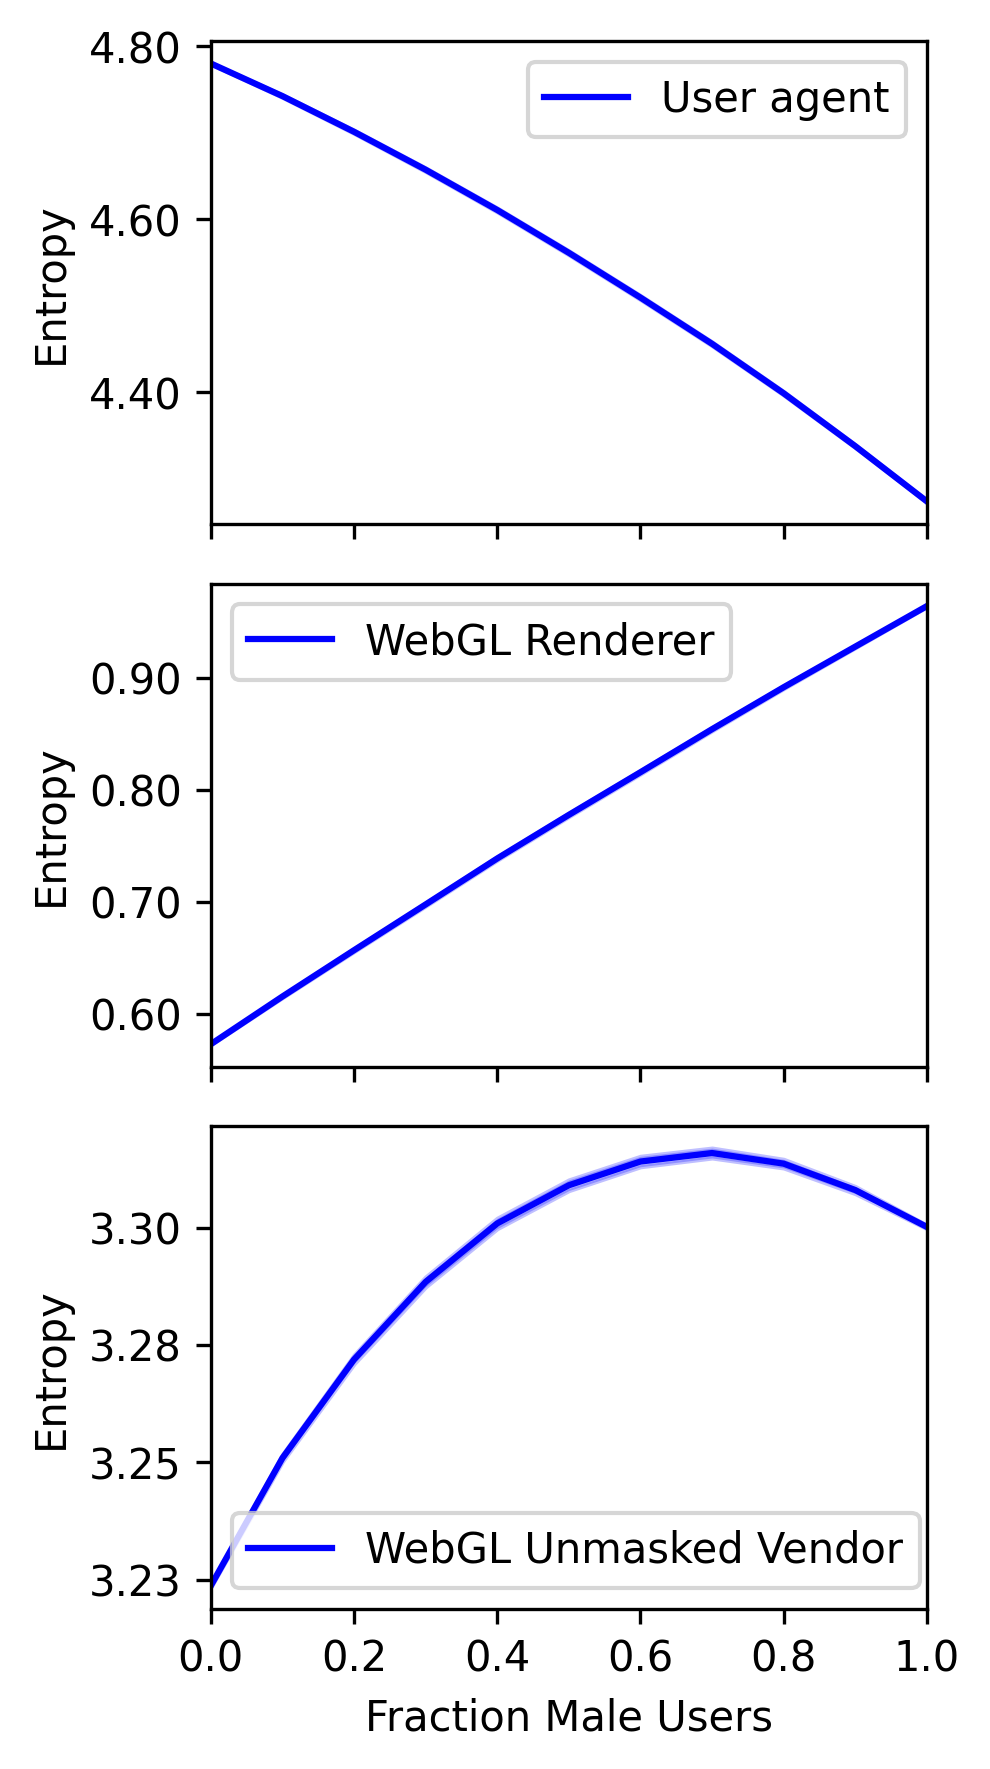

In [ ]:
from matplotlib.ticker import FormatStrFormatter

"""
Select subset of interesting attributes to show
User agent of great interest in previous studies, as a higher entropy source
and since then browser changes have been made to reduce User agent entropy
User agent largely dependent on software, entropy decreases as fraction Male increases
vs WebGL Renderer is largely dependent on hardware, and entropy increases as fraction Male increases
"""
color = colors[0]
attrs = ['User agent', 'WebGL Renderer', 'WebGL Unmasked Vendor']
fig, axes = plt.subplots(len(attrs), 1,figsize=(3.4,len(attrs)*2), sharex=True, dpi=300)
for i, a in enumerate(attrs):
  ax = axes[i]
  idx = p_male_e_df.transpose()[a].index.astype(float)
  ax.plot(idx, p_male_e_df.transpose()[a], label=a, color=color)
  ax.fill_between(idx, p_male_e_df_95CI_lower.transpose()[a], p_male_e_df_95CI_upper.transpose()[a], color=color,alpha=0.25)
  ax.set_xlim(0, 1)
  if i==(len(attrs)-1): ax.set_xlabel('Fraction Male Users')
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  ax.set_ylabel('Entropy')
  _ = ax.legend()
plt.tight_layout()
plt.show()

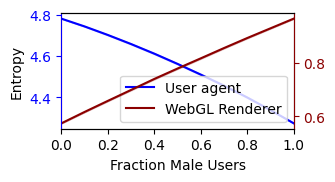

In [ ]:
# same plot
a1 = 'User agent'
a2 = 'WebGL Renderer'
c1 = colors[0]
c2 = colors[1]
fig, ax = plt.subplots(1,1,figsize=(3,1.5), dpi=100)
ax.set_xlim(0,1)
ax2 = ax.twinx()
idx = p_male_e_df.transpose().index.astype(float)
lns = ax.plot(idx, p_male_e_df.transpose()[a1], label='User agent', color=c1)
ax.fill_between(idx, p_male_e_df_95CI_lower.transpose()[a1], p_male_e_df_95CI_upper.transpose()[a1], color=c1, alpha=0.25)
ax.spines['left'].set_color('red')
lns += ax2.plot(idx, p_male_e_df.transpose()[a2], label=a2, color=c2)
ax2.fill_between(idx, p_male_e_df_95CI_lower.transpose()[a2], p_male_e_df_95CI_upper.transpose()[a2], color=c2, alpha=0.25)
ax.set_ylabel('Entropy')
ax.set_xlabel('Fraction Male Users')
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='lower right')
ax2.spines['left'].set_color(c1)
ax2.spines['right'].set_color(c2)
ax.tick_params(axis='y', colors=c1)
ax2.tick_params(axis='y', colors=c2)

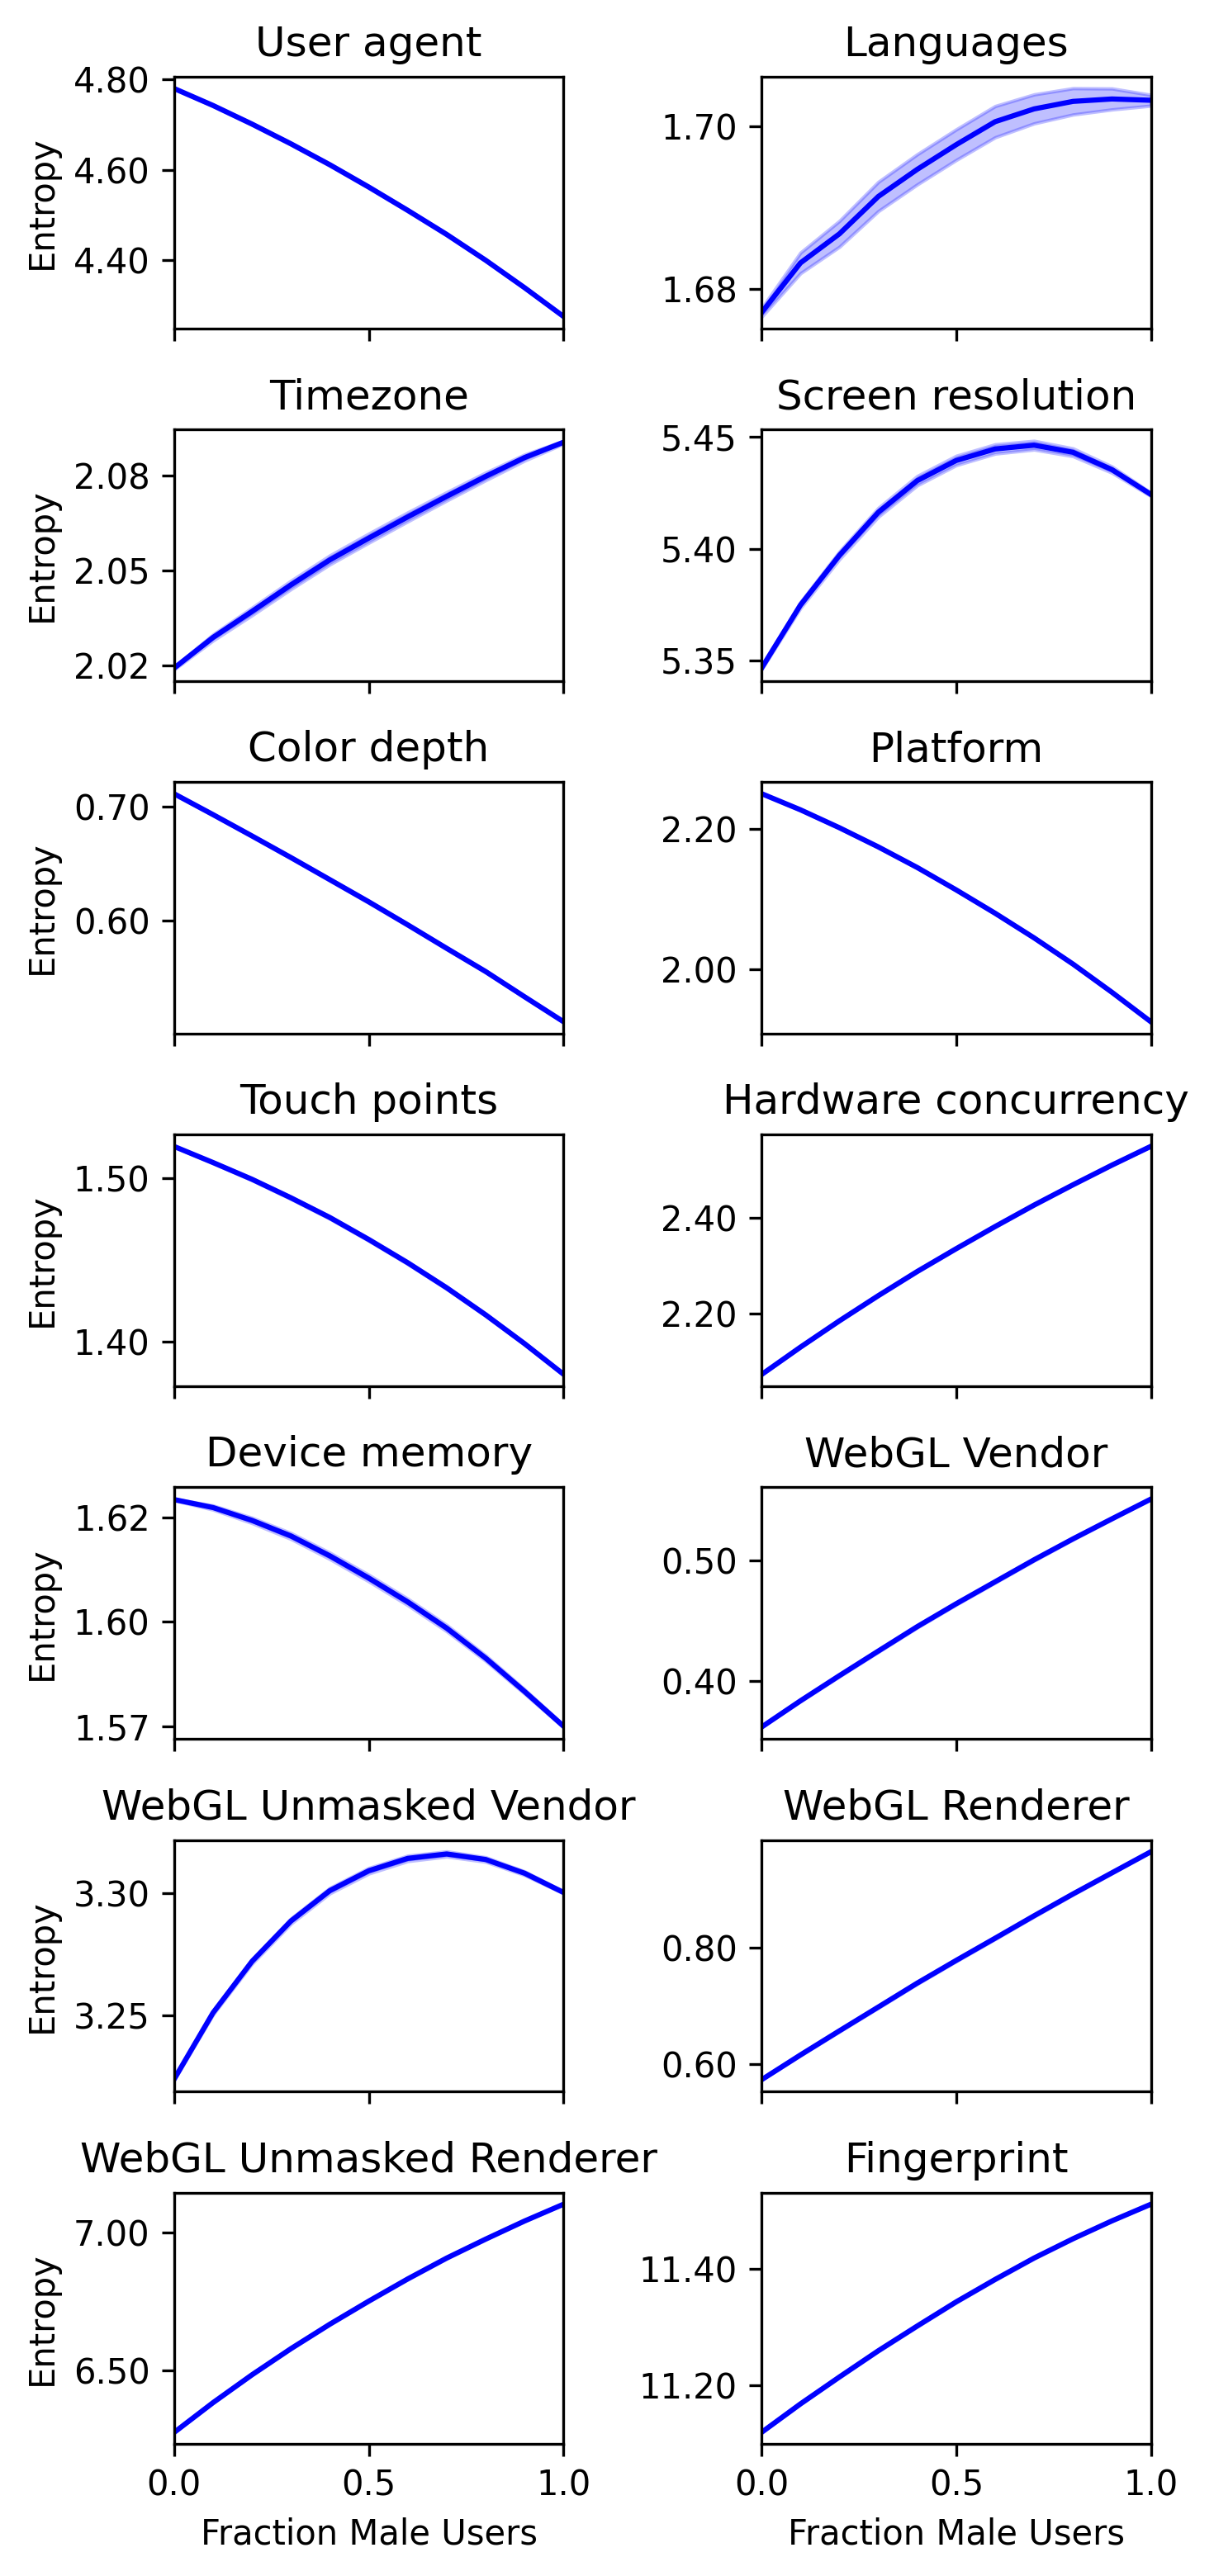

In [ ]:
color = colors[0]
# Plot them on separate subplots because they have different scales
fig, axes = plt.subplots(7,2,figsize=(5, 0.75*len(attribute_names)), sharex=True, dpi=300)
for i, a in enumerate(attribute_names):
  ax = axes.flatten()[i]
  idx = p_male_e_df.transpose()[a].index.astype(float)
  ax.plot(idx, p_male_e_df.transpose()[a], label=a, color=color)
  ax.fill_between(idx, p_male_e_df_95CI_lower.transpose()[a], p_male_e_df_95CI_upper.transpose()[a], color=color,alpha=0.25)
  ax.set_xlim(0, 1)
  if i in [12,13]: ax.set_xlabel('Fraction Male Users')
  if (i % 2) == 0: ax.set_ylabel('Entropy')
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  ax.set_title(a)
plt.tight_layout()


### Browser attribute and measurements by user group

Make Table for the entire sample:
```
Attribute, Distinct values, Entropy, % unique, Avg k
```

And for each demographic group:
```
Attribute, % unique, Avg k
```

Do this for each attributes and for the combined fingerprint.


Here's how we do this.

For each attribute:

1. get the value counts for all users. This defines anonymity sets and their sizes.

2. for each user, assign them their k for that attribute.
  - i.e. k is the size of the anonymity set they fall into for that atribute.

3. Compute % unique:
  - a. Count number of users s.t. k=1
  - b. Devide by total number of users

  - when doing this for specific demographic: change steps 3.a and 3.b to only count and devide over users in demographic group

5. Compute avg k:
  - Compute mean over the users' values of k
  - when doing this for specific demographic: only do computation over users in that demographic group


Implementation:
- Copy the dataframe and then from each attribute, A_i, add a column A_i:k which will hold the users' k values.

Also use the value counts (1) to compute (Shannon) entropy.


In [ ]:
def get_a_k_colname(attribute_name):
  return '%s:k' % attribute_name

def get_attr_k(df, attribute_name):
  anonymity_sets_k = df[attribute_name].value_counts().to_dict()
  return df[attribute_name].apply(lambda v: anonymity_sets_k[v])

def assign_attr_k(df, attribute_name):
  """Adds a column indicating the anonymity set size, k, for the attribute."""
  df[get_a_k_colname(attribute_name)] = get_attr_k(df, attribute_name)
  return df

In [ ]:
def get_pct_unique(df, attribute_name, roundto=1):
  n_unique = len(df[df[get_a_k_colname(attribute_name)]==1])
  return round(100*n_unique/len(df), roundto)

def get_mean_k(df, attribute_name, roundto=1):
  return round(df[get_a_k_colname(attribute_name)].mean(), roundto)

random_state = 1
def get_random_subsample(df, n, r=0):
  """Returns random subsample of size n."""
  return df.sample(n=n, replace=False, random_state=random_state+r)


#### Evaluating changes in scale/sample size vs fingerprinting metrics
To help understand the relationship between sample size and our fingerprinting metrics, we use repeated random sampling to create a series of subsamples of incremental sizes, n, and compute the percent unique and average k for each such n.

We create subsamples of size n=200, 400, … 8000 (increments of 200)
For each n, we use random sampling, without replacement, to create the subsample and compute metrics for n. We repeat this process 1000 times for each n in order to compute the mean values with 95% confidence intervals.

Plot: sample size versus fingerprinting risk
- X-axis: n
- Y-axis left: % unique (mean over samples with 95% CIs)
- Y-axis right: avk k


To do this, develop functions:

- random sampling process to return subsample of size n
- given subsample: compute % unique, avg k


In [ ]:
ns = [i for i in range(200, 8000+1, 200)]

def get_n_resampled_f_metrics(df=sba_df, attribute_name='Fingerprint', ns=ns, repeated_samples=1000):
  """
  Compute fingerprinting metrics for varying n with upper & lower 95% confidence intervals
  for each value of n: [mean, lower_95, upper_95] computed over 1000 random sampling processes

  Returns a dataframe with columns:
  n, % unique (mean), % unique (lower 95%), % unique (upper 95%), avg k (mean), avg k (lower 95%), avg k (upper 95%)
  """
  pct_unique_mean = []
  pct_unique_lower95 = []
  pct_unique_upper95 = []
  avg_k_mean = []
  avg_k_lower95 = []
  avg_k_upper95 = []
  for i, n in enumerate(ns):
    if (i % 10 == 0): print('%s: %s/%s: n=%s' % (pd.Timestamp.now(), i, len(ns), n))
    pct_unique = []
    avg_k = []
    for r in range(repeated_samples):
      subsample_df = get_random_subsample(df, n, r)
      subsample_df = assign_attr_k(subsample_df, attribute_name)
      pct_unique += [get_pct_unique(subsample_df, attribute_name)]
      avg_k += [get_mean_k(subsample_df, attribute_name)]
    (pct_unique_mean_, pct_unique_lower95_, pct_unique_upper95_) = get_mean_95CIs(pct_unique)
    pct_unique_mean += [pct_unique_mean_]
    pct_unique_lower95 += [pct_unique_lower95_]
    pct_unique_upper95 += [pct_unique_upper95_]
    (avg_k_mean_, avg_k_lower95_, avg_k_upper95_) = get_mean_95CIs(avg_k)
    avg_k_mean += [avg_k_mean_]
    avg_k_lower95 += [avg_k_lower95_]
    avg_k_upper95 += [avg_k_upper95_]
  return pd.DataFrame({
      'n': ns,
      '% unique': pct_unique_mean,
      '% unique (lower 95%)': pct_unique_lower95,
      '% unique (upper 95%)': pct_unique_upper95,
      'avg k': avg_k_mean,
      'avg k (lower 95%)': avg_k_lower95,
      'avg k (upper 95%)': avg_k_upper95,
  }).set_index('n')

In [ ]:
n_f_metrics_Fingerprint_fpath = drive_computed_fpath + '/n_f_metrics_Fingerprint.csv'

do_compute_n_f_metrics = False
# do_compute_n_f_metrics = True
if do_compute_n_f_metrics:
  n_f_metrics_df = get_n_resampled_f_metrics(df=sba_df, attribute_name='Fingerprint', ns=ns, repeated_samples=1000)
  n_f_metrics_df.to_csv(n_f_metrics_Fingerprint_fpath)

n_f_metrics_df = pd.read_csv(n_f_metrics_Fingerprint_fpath).set_index('n')
n_f_metrics_df.head(3)

,% unique,% unique (lower 95%),% unique (upper 95%),avg k,avg k (lower 95%),avg k (upper 95%)
n,,,,,,
200,94.1730,94.029435,94.316565,1.0816,1.077528,1.085672
400,90.6131,90.490561,90.735639,1.1694,1.165070,1.173730
600,87.9130,87.807020,88.018980,1.2532,1.248509,1.257891


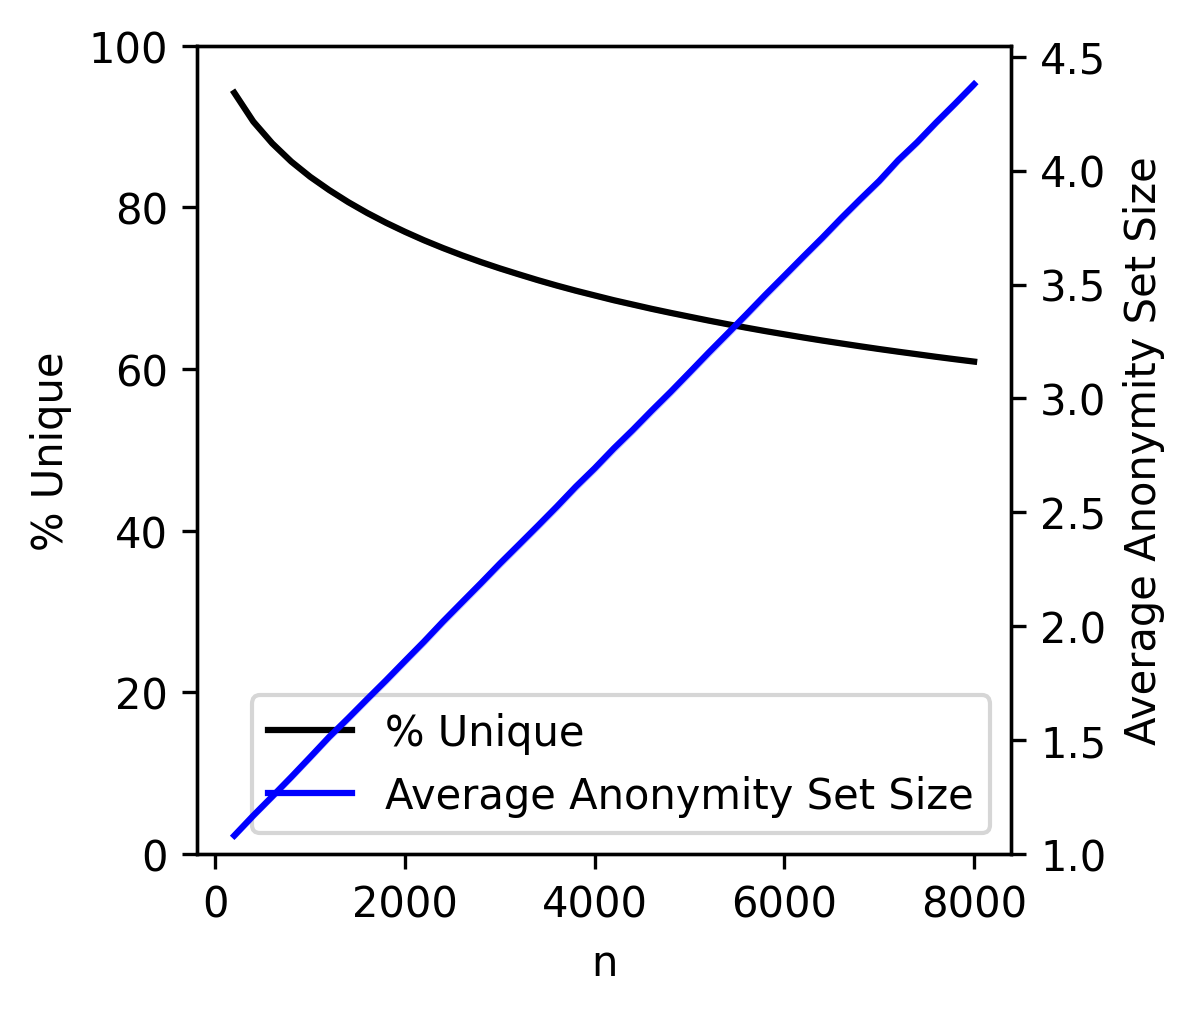

In [ ]:
# Plot the data
fig, ax = plt.subplots(1,1,figsize=(3.5,3.5), dpi=300)
lns = ax.plot(n_f_metrics_df.index, n_f_metrics_df['% unique'], color='black', label='% Unique')
ax.fill_between(n_f_metrics_df.index, n_f_metrics_df['% unique (lower 95%)'], n_f_metrics_df['% unique (upper 95%)'], color='black',alpha=0.25)
ax2 = ax.twinx()
lns += ax2.plot(n_f_metrics_df.index, n_f_metrics_df['avg k'], color='blue', label='Average Anonymity Set Size')
ax2.fill_between(n_f_metrics_df.index, n_f_metrics_df['avg k (lower 95%)'], n_f_metrics_df['avg k (upper 95%)'], color=colors[0], alpha=0.25)
ax.set_ylim(0,100)
ax.set_ylabel('% Unique')
ax2.set_ylim(1)
ax.set_xlabel('n')
ax2.set_ylabel('Average Anonymity Set Size')
labs = [l.get_label() for l in lns]
_ = ax.legend(lns, labs, loc='lower right')
# _ = ax.set_title('Sample size vs fingerprinting metric')

Sample size vs avg k/n


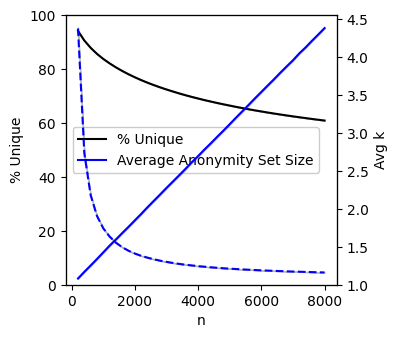

In [ ]:
# Question: Does avg k/n approach a limit?
n_f_metrics_df['avg k/n'] = n_f_metrics_df['avg k']/n_f_metrics_df.index
n_f_metrics_df['avg k/n (lower 95%)'] = n_f_metrics_df['avg k (lower 95%)']/n_f_metrics_df.index
n_f_metrics_df['avg k/n (upper 95%)'] = n_f_metrics_df['avg k (upper 95%)']/n_f_metrics_df.index

# Plot the data
fig, ax = plt.subplots(1,1,figsize=(3.5,3.5), dpi=100)
lns = ax.plot(n_f_metrics_df.index, n_f_metrics_df['% unique'], color='black', label='% Unique')
ax.fill_between(n_f_metrics_df.index, n_f_metrics_df['% unique (lower 95%)'], n_f_metrics_df['% unique (upper 95%)'], color='black',alpha=0.25)
ax2 = ax.twinx()
lns += ax2.plot(n_f_metrics_df.index, n_f_metrics_df['avg k'], color='blue', label='Avg k')
ax2.fill_between(n_f_metrics_df.index, n_f_metrics_df['avg k (lower 95%)'], n_f_metrics_df['avg k (upper 95%)'], color=colors[0], alpha=0.25)
ax.set_ylim(0,100)
ax.set_ylabel('% Unique')
ax2.set_ylim(1)
ax.set_xlabel('n')
ax2.set_ylabel('Avg k')
ax3 = ax.twinx()
lns += ax3.plot(n_f_metrics_df.index, n_f_metrics_df['avg k/n'], linestyle='--', color=colors[0], label='Avg k/n')
ax3.fill_between(n_f_metrics_df.index, n_f_metrics_df['avg k/n (lower 95%)'], n_f_metrics_df['avg k/n (upper 95%)'], color='black', alpha=0.25)
ax3.set_yticks([])
legend = ax.legend(lns, labs, loc='center left', framealpha=1, facecolor='white')
print('Sample size vs avg k/n')

### Metrics tables

Create tables showing % unique and avg k for each group

- First without any subsampling process
- Then with repeated subsampling process

In [ ]:
attribute_names = stable_ba_names + ['Fingerprint'] # Used to include F(passive)

In [ ]:
sample_df = sba_df.copy()
for i, a_i in enumerate(attribute_names):
  sample_df = assign_attr_k(sample_df, a_i)
sample_df.head(3)

,Age,Gender,Hispanic,Race,Income,User agent,Languages,Timezone,Screen resolution,Color depth,Platform,Touch points,WebGL Vendor,WebGL Renderer,WebGL Unmasked Vendor,WebGL Unmasked Renderer,Hardware concurrency,Device memory,Age6,Income6,Fingerprint,F(passive),User agent:k,Languages:k,Timezone:k,Screen resolution:k,Color depth:k,Platform:k,Touch points:k,Hardware concurrency:k,Device memory:k,WebGL Vendor:k,WebGL Unmasked Vendor:k,WebGL Renderer:k,WebGL Unmasked Renderer:k,Fingerprint:k
ResponseId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
R_107DpGEXCf0M8mM,35 - 54 years,Male,No,White,"$50,000 - $99,999",Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,"en-US,en",America/New_York,"[900,1600]",24,Win32,0,WebKit,WebKit WebGL,Google Inc. (Intel),"ANGLE (Intel, Intel(R) HD Graphics 3000 Direct...",8.0,8.0,45 - 54 years,"$75,000 - $99,999",4515016852565782563,-7822458429846485452,2875,5691,4000,176,7464,4210,4647,2911,4489,7622,2293,7622,19,1
R_108GtMMONtiVpcZ,35 - 54 years,Male,No,White,"Less than $50,000",Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,"en-US,en",America/Los_Angeles,"[900,1440]",24,Win32,0,WebKit,WebKit WebGL,Google Inc. (NVIDIA),"ANGLE (NVIDIA, NVIDIA GeForce RTX 3060 (0x0000...",12.0,8.0,35 - 44 years,"$25,000 - $49,999",-3859415766035396020,1227504678769523705,73,5691,1371,716,7464,4210,4647,782,4489,7622,932,7622,12,1
R_1090e2cXjsXnTzl,35 - 54 years,Female,No,White,"$50,000 - $99,999",Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,"en-US,en",America/Chicago,"[720,1280]",24,Win32,10,WebKit,WebKit WebGL,Google Inc. (Google),"ANGLE (Google, Vulkan 1.3.0 (SwiftShader Devic...",8.0,8.0,45 - 54 years,"$50,000 - $74,999",9158963314034085064,9061800043928609635,96,5691,2229,337,7464,4210,1039,2911,4489,7622,364,7622,362,1


Make a table with metrics for all users:

```
Attribute name, distinct values, % unique, avg k
```

In [ ]:
# Make the table representing all users together
print('N=%s' % len(sample_df))
overall_df = pd.DataFrame({
    'Attribute': attribute_names,
    'Distinct values': [sample_df[a].nunique() for a in attribute_names],
    '% unique': [get_pct_unique(sample_df, a) for a in attribute_names],
    'avg k': [get_mean_k(sample_df, a) for a in attribute_names]
}).set_index('Attribute')
overall_df

N=8400


,Distinct values,% unique,avg k
Attribute,,,
User agent,434,2.8,1185.2
Languages,264,2.4,4333.0
Timezone,49,0.2,2735.2
Screen resolution,572,4.5,505.3
Color depth,3,0.0,6684.5
Platform,12,0.0,2618.4
Touch points,11,0.0,3520.5
Hardware concurrency,24,0.1,2290.3
Device memory,7,0.0,3272.0


Make tables for specific demographic groups.

In [ ]:
def get_demos_metrics_df(sample_df, D, D_groups, attribute_names=attribute_names):
  df = None
  for demo in D_groups:
    demo_df = sample_df[sample_df[D]==demo]
    ddf = pd.DataFrame({
            'Attribute': attribute_names,
            '%s: %% unique'%demo: [get_pct_unique(demo_df, a_i) for a_i in attribute_names],
            '%s: avg k'%demo: [get_mean_k(demo_df, a_i) for a_i in attribute_names]
          }).set_index('Attribute')
    df = ddf if (df is None) else df.merge(ddf, left_index=True, right_index=True)
  return df

In [ ]:
Ds6_w_Other = {
    'Gender': ['Male','Female', 'Other'],
    'Age6': sorted(sba_df['Age6'].unique()),
    'Income6': income6_groups,
    'Hispanic': ['Yes', 'No'],
    'Race': ['White','Black','Asian','Other or mixed'],
}

# Merge all these into one df
all_demos_df = overall_df.copy()
for D, D_groups in Ds6_w_Other.items():
  df = get_demos_metrics_df(sample_df, D, D_groups)
  all_demos_df = all_demos_df.merge(df, left_index=True, right_index=True)

# all_demos_df

Print for easy copying

In [ ]:
df = overall_df
print('N=%s'%N)
display(df.reset_index().astype(str).style.hide(axis="index"))
# print(df.reset_index().astype(str).style.hide(axis="index").to_latex())

N=8400


Attribute,Distinct values,% unique,avg k
User agent,434,2.8,1185.2
Languages,264,2.4,4333.0
Timezone,49,0.2,2735.2
Screen resolution,572,4.5,505.3
Color depth,3,0.0,6684.5
Platform,12,0.0,2618.4
Touch points,11,0.0,3520.5
Hardware concurrency,24,0.1,2290.3
Device memory,7,0.0,3272.0
WebGL Vendor,3,0.0,6983.5


In [ ]:
for di, (D_name, D_groups) in enumerate(Ds6_w_Other.items()):
  # if di > 0: break
  # convert to str for nicer printing
  D_df = get_demos_metrics_df(sample_df, D_name, D_groups).astype(str)
  D_group_sizes = sample_df[D_name].value_counts().rename('n').to_frame().loc[D_groups].transpose().astype(str)
  D_unicity = D_df[[c for c in D_df.columns if '% unique' in c]]
  D_avg_k = D_df[[c for c in D_df.columns if 'avg k' in c]]
  D_unicity.columns = D_avg_k.columns = D_groups
  D_unicity = pd.concat([D_group_sizes, D_unicity])
  D_avg_k = pd.concat([D_group_sizes, D_avg_k])
  if D_groups == ['Yes', 'No']:
    D_unicity.columns = D_avg_k.columns = ['Hispanic', 'Non-hispanic']
  D_unicity.index.name = D_avg_k.index.name = 'Attribute'
  print('%% Unique: %s: %s' % (D_name, D_groups))
  display(D_unicity.reset_index().style.hide(axis="index"))
  # print(D_unicity.reset_index().style.hide(axis="index").to_latex())
  print('Avg k: %s: %s' % (D_name, D_groups))
  display(D_avg_k.reset_index().style.hide(axis="index"))
  # print(D_avg_k.reset_index().style.hide(axis="index").to_latex())

% Unique: Gender: ['Male', 'Female', 'Other']


Attribute,Male,Female,Other
n,4227,3990,183
User agent,2.7,2.8,3.8
Languages,2.6,2.0,4.4
Timezone,0.2,0.3,0.0
Screen resolution,5.8,2.9,8.2
Color depth,0.0,0.0,0.0
Platform,0.0,0.1,0.0
Touch points,0.0,0.0,0.0
Hardware concurrency,0.1,0.0,0.0
Device memory,0.0,0.0,0.0


Avg k: Gender: ['Male', 'Female', 'Other']


Attribute,Male,Female,Other
n,4227,3990,183
User agent,1309.9,1055.7,1128.3
Languages,4422.8,4237.2,4346.5
Timezone,2706.8,2772.7,2573.9
Screen resolution,549.2,459.7,484.2
Color depth,6856.7,6503.1,6661.1
Platform,2875.5,2340.2,2747.0
Touch points,3664.7,3378.1,3293.6
Hardware concurrency,2119.1,2476.1,2192.1
Device memory,3372.0,3164.7,3303.9


% Unique: Age6: ['18 - 24 years', '25 - 34 years', '35 - 44 years', '45 - 54 years', '55 - 64 years', '65 or older']


Attribute,18 - 24 years,25 - 34 years,35 - 44 years,45 - 54 years,55 - 64 years,65 or older
n,1302,2859,2024,1158,712,345
User agent,2.9,2.8,2.8,2.3,2.9,3.2
Languages,2.0,2.4,2.3,2.8,2.5,1.7
Timezone,0.5,0.1,0.1,0.4,0.3,0.0
Screen resolution,2.5,4.8,4.9,4.0,5.9,6.7
Color depth,0.0,0.0,0.0,0.0,0.0,0.0
Platform,0.0,0.0,0.0,0.0,0.0,0.3
Touch points,0.0,0.0,0.0,0.0,0.1,0.0
Hardware concurrency,0.1,0.1,0.0,0.0,0.0,0.3
Device memory,0.0,0.0,0.0,0.0,0.0,0.0


Avg k: Age6: ['18 - 24 years', '25 - 34 years', '35 - 44 years', '45 - 54 years', '55 - 64 years', '65 or older']


Attribute,18 - 24 years,25 - 34 years,35 - 44 years,45 - 54 years,55 - 64 years,65 or older
n,1302,2859,2024,1158,712,345
User agent,1103.5,1159.1,1216.0,1184.5,1236.3,1425.4
Languages,4215.9,4251.5,4339.7,4465.5,4540.3,4538.3
Timezone,2672.2,2706.9,2756.2,2764.3,2862.8,2724.1
Screen resolution,542.3,501.9,502.4,485.1,496.1,496.7
Color depth,6287.5,6602.7,6803.8,6914.2,6933.3,6876.0
Platform,2525.1,2595.5,2615.4,2640.9,2711.8,2910.4
Touch points,3591.1,3574.1,3477.9,3438.4,3439.1,3502.7
Hardware concurrency,2240.9,2249.6,2278.9,2360.7,2439.8,2336.0
Device memory,3480.6,3332.1,3210.7,3075.9,3138.8,3280.8


% Unique: Income6: ['Less than $25,000', '$25,000 - $49,999', '$50,000 - $74,999', '$75,000 - $99,999', '$100,000 - $149,999', '$150,000 or more']


Attribute,"Less than $25,000","$25,000 - $49,999","$50,000 - $74,999","$75,000 - $99,999","$100,000 - $149,999","$150,000 or more"
n,1097,1842,1692,1267,1411,951
User agent,4.5,3.4,2.7,2.0,2.3,1.6
Languages,2.3,2.6,2.2,2.7,2.0,2.4
Timezone,0.3,0.1,0.3,0.2,0.2,0.4
Screen resolution,5.8,4.3,4.7,4.7,3.8,3.7
Color depth,0.0,0.0,0.0,0.0,0.0,0.0
Platform,0.0,0.1,0.1,0.0,0.0,0.0
Touch points,0.0,0.0,0.1,0.0,0.0,0.0
Hardware concurrency,0.0,0.1,0.1,0.1,0.0,0.0
Device memory,0.0,0.0,0.1,0.0,0.0,0.0


Avg k: Income6: ['Less than $25,000', '$25,000 - $49,999', '$50,000 - $74,999', '$75,000 - $99,999', '$100,000 - $149,999', '$150,000 or more']


Attribute,"Less than $25,000","$25,000 - $49,999","$50,000 - $74,999","$75,000 - $99,999","$100,000 - $149,999","$150,000 or more"
n,1097,1842,1692,1267,1411,951
User agent,1168.9,1173.0,1200.6,1231.0,1220.2,1090.1
Languages,4469.5,4440.6,4313.8,4276.4,4328.7,4072.7
Timezone,2637.8,2758.1,2714.3,2823.5,2719.1,2736.1
Screen resolution,501.2,523.7,500.1,512.2,498.2,484.8
Color depth,6787.9,6822.0,6674.2,6602.7,6651.0,6515.6
Platform,2654.3,2658.5,2631.7,2666.6,2640.3,2389.1
Touch points,3553.6,3556.3,3510.6,3568.5,3451.8,3450.3
Hardware concurrency,2276.3,2262.1,2312.0,2248.7,2348.0,2309.8
Device memory,3046.0,3100.9,3250.4,3391.9,3438.7,3476.7


% Unique: Hispanic: ['Yes', 'No']


Attribute,Hispanic,Non-hispanic
n,923,7477
User agent,3.0,2.8
Languages,2.9,2.3
Timezone,0.2,0.2
Screen resolution,4.6,4.5
Color depth,0.0,0.0
Platform,0.0,0.0
Touch points,0.0,0.0
Hardware concurrency,0.0,0.1
Device memory,0.0,0.0


Avg k: Hispanic: ['Yes', 'No']


Attribute,Hispanic,Non-hispanic
n,923,7477
User agent,1121.3,1193.1
Languages,3986.8,4375.7
Timezone,2400.8,2776.5
Screen resolution,505.9,505.2
Color depth,6645.5,6689.3
Platform,2558.9,2625.8
Touch points,3531.8,3519.1
Hardware concurrency,2236.2,2297.0
Device memory,3294.7,3269.2


% Unique: Race: ['White', 'Black', 'Asian', 'Other or mixed']


Attribute,White,Black,Asian,Other or mixed
n,5911,938,842,709
User agent,2.5,3.6,2.1,4.7
Languages,2.0,2.2,4.3,3.1
Timezone,0.3,0.2,0.0,0.0
Screen resolution,4.4,4.2,5.1,4.8
Color depth,0.0,0.0,0.0,0.0
Platform,0.0,0.0,0.0,0.0
Touch points,0.0,0.0,0.1,0.0
Hardware concurrency,0.0,0.0,0.2,0.1
Device memory,0.0,0.0,0.0,0.0


Avg k: Race: ['White', 'Black', 'Asian', 'Other or mixed']


Attribute,White,Black,Asian,Other or mixed
n,5911,938,842,709
User agent,1170.8,1211.0,1339.7,1087.8
Languages,4406.0,4431.7,3937.4,4063.4
Timezone,2774.7,2953.1,2481.2,2419.3
Screen resolution,505.0,487.3,537.8,492.7
Color depth,6721.9,6889.6,6317.9,6536.5
Platform,2599.2,2743.8,2717.1,2495.5
Touch points,3524.6,3357.6,3685.2,3506.1
Hardware concurrency,2293.7,2436.9,2119.7,2270.3
Device memory,3258.4,3035.5,3641.0,3260.3


### Metrics tables computed over repeated random sampling process

Subsampling to create samples with equal proportions of each demographic group.
- Use consistent n(=1800)
- n chosen to account for size of smallest group want to represent: Hispanic: Yes has n~930 → 2 x 900 = 1800
- Use n=1800 because it is divisible by 3 and 4 and 6 (6 useful if we do not aggregate income and age groups).
- Using n << N useful for resampling so that the same users are not sampled each time

For each demographic category: Gender (binary Male/Female), Age, Hispanic (binary Yes/No), Race, Income:
- Use random sampling (without replacement) to create a subsample with equal proportions of each demographic group (e.g. for Gender: Male n=n/2, Female n=n/2)
- Compute % unique and avg k metrics specific to this subsample
- Use repeated random sampling to do this process many  times to then compute a mean and 95% confidence intervals for each metric.
- Excludes Gender: Other because n too small


In [ ]:
def get_random_subsample_equal_proportions(df, D_name, D_groups, n, r=0):
  """Returns a random sample with equal proportions of each group in D_groups."""
  if n % len(D_groups) != 0:
    raise Exception('n is not divisible by number of demographic groups')
  d_n = int(n/len(D_groups))
  return pd.concat([df[df[D_name]==d].sample(n=d_n, replace=False, random_state=random_state+r) for d in D_groups])

# Little test
subsampled_df = get_random_subsample_equal_proportions(sba_df, 'Gender', ['Male', 'Female'], 100)
assert(subsampled_df['Gender'].value_counts()['Male'] == 50)
assert(subsampled_df['Gender'].value_counts()['Female'] == 50)

In [ ]:
n = 1800


def get_resampled_metrics_w_equal_demo_groups(df, n, D_name, D_groups, repeated_samples=1000, verbose=True):
  """
  Get metrics computed over a repeated random resampling process
  where each subsample has equal proportions of demographic groups.
  % unique and avg k are computed specific to each group,
  but where they are computed in the context of the entire subsample.
  n: size of subsample overall. Each group in D_groups then has size n/number of groups.
  """
  # for each d in D_groups: created a list of lists where each sublist is for a given Attribute, a, and includes values computed for the r-th subsample
  # {a0:[%unique_a0_r0, %unique_a0_r1, ....], a1:[%unique_a1_r0, %unique_a1_r1, ...], ... for each a}
  # {a0:[avgk_a0_r0, avgk_a0_r1, ...], a1:[avgk_a1_r0, avgk_a1_r1, ...], ... for each a}
  D_metrics = {d: {'pct_unique_samples': {a:[] for a in attribute_names}, 'avgk_samples': {a:[] for a in attribute_names}} for d in D_groups}
  for r in range(repeated_samples):
    if verbose and (r % max(100, repeated_samples/5) == 0):
      print('%s: resampling %s/%s for %s: %s groups' % (pd.Timestamp.now(), r+1, repeated_samples, D_name, len(D_groups)))
    # get resampled dataframe, with equal proportions of each demographic group in D
    subsampled_df = get_random_subsample_equal_proportions(df, D_name, D_groups, n, r=r)
    # assign k values for each attribute specific to this subsample; assignment is across all D_groups
    for a_i, a in enumerate(attribute_names):
      subsampled_df = assign_attr_k(subsampled_df, a)
      for d in D_groups:
        d_subsampled_df = subsampled_df[subsampled_df[D_name]==d]
        D_metrics[d]['pct_unique_samples'][a] += [get_pct_unique(d_subsampled_df, a)]
        D_metrics[d]['avgk_samples'][a] += [get_mean_k(d_subsampled_df, a)]
  # Now all the sampled metrics are collected -- aggregate to means with 95% CIs
  # And put in a dataframe
  dfs = []
  for d in D_groups:
    D_metrics[d]['pct_unique'] = {a: get_formatted_mean_95CIs(D_metrics[d]['pct_unique_samples'][a]) for a in attribute_names}
    D_metrics[d]['avgk'] = {a: get_formatted_mean_95CIs(D_metrics[d]['avgk_samples'][a]) for a in attribute_names}
    dfs += [pd.DataFrame({
        'Attribute': attribute_names,
        '%s: %% Unique'%d: [D_metrics[d]['pct_unique'][a] for a in attribute_names],
        '%s: Avg k'%d: [D_metrics[d]['avgk'][a] for a in attribute_names],
    }).set_index('Attribute')]
  # Return one dataframe
  return pd.concat(dfs, axis=1, join='inner')

In [ ]:
def get_resampled_metrics_w_equal_demo_groups_dfs(Ds, df, n=1800, repeated_samples=1000):
  sample_df = df.copy()
  # Get data for the overall sample, using n, without any demographic subgroups.
  # In order to use the exact same process as for the demographic groups,
  # create a dummy group that captures all
  sample_df['ALL'] = 'All'
  all_resampled_df = get_resampled_metrics_w_equal_demo_groups(sample_df, n, 'ALL', ['All'], repeated_samples=repeated_samples)
  Ds_resampled_metrics_dfs = {'All': all_resampled_df} # map D name to df
  for D_name, D_groups in Ds.items():
    print('n=%s'%n, D_name, D_groups)
    Ds_resampled_metrics_dfs[D_name] = get_resampled_metrics_w_equal_demo_groups(sample_df, n, D_name, D_groups, repeated_samples=repeated_samples)
  return Ds_resampled_metrics_dfs
  #return pd.concat([df for df in Ds_resampled_metrics_dfs.values()], axis=1, join='inner')

In [ ]:
Ds = {
    'Gender': ['Male','Female'],
    'Age': sorted(sba_df['Age'].unique()),
    'Income': income_groups,
    'Hispanic': ['Yes', 'No'],
    'Race': ['White','Black','Asian','Other or mixed'],
}

def get_fname(D_name):
  return drive_computed_fpath + '/f_metrics_repeated_sample_n%s_%s.csv'%(n,D_name)


do_recompute_metrics = False
# do_recompute_metrics = True
resampled_metrics_dfs = {}
if do_recompute_metrics:
  resampled_metrics_dfs = get_resampled_metrics_w_equal_demo_groups_dfs(Ds, sba_df, n=n)
  for D_name in (['All'] + list(Ds.keys())):
    fname = get_fname(D_name)
    print('%s: saving to %s' % (D_name, fname))
    resampled_metrics_dfs[D_name].to_csv(fname)

for D_name in (['All'] + list(Ds.keys())):
  fname = get_fname(D_name)
  resampled_metrics_dfs[D_name] = pd.read_csv(fname, index_col=0)

resampled_metrics_df = pd.concat([df for df in resampled_metrics_dfs.values()], axis=1, join='inner')
resampled_metrics_df.head()

,All: % Unique,All: Avg k,Male: % Unique,Male: Avg k,Female: % Unique,Female: Avg k,18 - 34 years: % Unique,18 - 34 years: Avg k,35 - 54 years: % Unique,35 - 54 years: Avg k,55 or older: % Unique,55 or older: Avg k,"Less than $50,000: % Unique","Less than $50,000: Avg k","$50,000 - $99,999: % Unique","$50,000 - $99,999: Avg k","$100,000 or more: % Unique","$100,000 or more: Avg k",Yes: % Unique,Yes: Avg k,No: % Unique,No: Avg k,White: % Unique,White: Avg k,Black: % Unique,Black: Avg k,Asian: % Unique,Asian: Avg k,Other or mixed: % Unique,Other or mixed: Avg k
Attribute,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
User agent,"5.9 [5.9, 5.9]","254.9 [254.2, 255.6]","5.5 [5.5, 5.6]","280.7 [279.9, 281.5]","6.3 [6.2, 6.3]","226.4 [225.7, 227.1]","6.1 [6.0, 6.2]","251.3 [250.4, 252.2]","5.6 [5.6, 5.7]","264.4 [263.5, 265.3]","6.2 [6.1, 6.2]","286.6 [285.8, 287.3]","7.4 [7.3, 7.4]","251.4 [250.5, 252.2]","5.4 [5.4, 5.5]","259.8 [258.9, 260.6]","4.8 [4.8, 4.9]","250.9 [250.1, 251.7]","5.4 [5.4, 5.4]","235.6 [235.3, 235.8]","6.1 [6.0, 6.1]","250.5 [249.7, 251.3]","5.8 [5.7, 5.8]","255.4 [254.5, 256.4]","7.2 [7.1, 7.2]","263.8 [263.0, 264.6]","4.7 [4.6, 4.7]","294.4 [293.6, 295.2]","7.6 [7.6, 7.7]","237.4 [236.8, 238.0]"
Languages,"3.4 [3.4, 3.5]","929.6 [928.5, 930.8]","3.9 [3.8, 3.9]","947.3 [946.0, 948.6]","2.9 [2.9, 3.0]","908.3 [907.1, 909.5]","3.4 [3.3, 3.4]","919.9 [918.4, 921.3]","3.6 [3.6, 3.7]","952.8 [951.3, 954.3]","3.4 [3.4, 3.4]","988.4 [987.2, 989.6]","3.4 [3.4, 3.4]","952.9 [951.5, 954.3]","3.5 [3.5, 3.6]","920.6 [919.2, 922.0]","3.4 [3.3, 3.4]","905.3 [903.9, 906.6]","4.0 [4.0, 4.0]","828.3 [827.9, 828.7]","3.3 [3.3, 3.4]","905.0 [903.8, 906.2]","3.0 [2.9, 3.0]","919.1 [917.6, 920.6]","3.4 [3.3, 3.4]","923.4 [922.2, 924.6]","4.9 [4.9, 5.0]","822.3 [821.2, 823.5]","4.0 [4.0, 4.1]","849.3 [848.3, 850.4]"
Timezone,"0.6 [0.6, 0.6]","587.1 [586.3, 587.8]","0.6 [0.6, 0.6]","580.7 [579.9, 581.6]","0.6 [0.6, 0.6]","595.0 [594.2, 595.9]","0.7 [0.7, 0.7]","582.7 [581.8, 583.7]","0.6 [0.6, 0.7]","598.0 [597.1, 598.9]","0.5 [0.5, 0.5]","610.5 [609.8, 611.3]","0.4 [0.4, 0.4]","581.1 [580.3, 581.9]","0.7 [0.7, 0.8]","591.1 [590.2, 592.1]","0.6 [0.6, 0.7]","584.3 [583.4, 585.2]","0.5 [0.5, 0.5]","506.6 [506.4, 506.7]","0.6 [0.6, 0.6]","561.0 [560.3, 561.7]","0.7 [0.7, 0.7]","575.0 [574.0, 576.0]","0.6 [0.6, 0.6]","606.5 [605.7, 607.4]","0.2 [0.2, 0.2]","543.0 [542.3, 543.6]","0.3 [0.3, 0.3]","514.2 [513.7, 514.8]"
Screen resolution,"7.3 [7.2, 7.3]","109.0 [108.7, 109.3]","8.7 [8.7, 8.8]","118.0 [117.6, 118.4]","5.4 [5.4, 5.5]","99.2 [98.9, 99.4]","6.1 [6.1, 6.2]","109.3 [108.9, 109.6]","7.3 [7.3, 7.4]","106.9 [106.6, 107.3]","9.5 [9.5, 9.6]","108.2 [108.0, 108.5]","7.9 [7.8, 7.9]","110.8 [110.4, 111.1]","7.3 [7.2, 7.3]","108.7 [108.3, 109.0]","6.4 [6.4, 6.5]","106.0 [105.7, 106.4]","6.7 [6.7, 6.8]","110.3 [110.1, 110.4]","7.5 [7.4, 7.5]","109.1 [108.8, 109.5]","7.3 [7.2, 7.4]","109.1 [108.7, 109.5]","6.7 [6.7, 6.8]","105.8 [105.5, 106.0]","7.6 [7.5, 7.6]","116.1 [115.8, 116.4]","8.2 [8.2, 8.3]","106.5 [106.2, 106.7]"
Color depth,"0.0 [0.0, 0.0]","1433.3 [1432.0, 1434.5]","0.0 [0.0, 0.0]","1468.7 [1467.4, 1470.0]","0.0 [0.0, 0.0]","1393.1 [1391.6, 1394.5]","0.0 [0.0, 0.0]","1408.6 [1406.9, 1410.2]","0.0 [0.0, 0.0]","1482.9 [1481.5, 1484.2]","0.0 [0.0, 0.0]","1498.5 [1497.4, 1499.5]","0.0 [0.0, 0.0]","1459.2 [1457.7, 1460.7]","0.0 [0.0, 0.0]","1423.6 [1422.0, 1425.1]","0.0 [0.0, 0.0]","1412.8 [1411.3, 1414.3]","0.0 [0.0, 0.0]","1420.7 [1420.2, 1421.2]","0.0 [0.0, 0.0]","1430.8 [1429.5, 1432.1]","0.0 [0.0, 0.0]","1425.9 [1424.2, 1427.6]","0.0 [0.0, 0.0]","1460.9 [1459.8, 1462.1]","0.0 [0.0, 0.0]","1341.7 [1340.3, 1343.1]","0.0 [0.0, 0.0]","1386.9 [1385.7, 1388.1]"


In [ ]:
print('n=%s'%n)
for D_name, D_groups in Ds.items():
  df = get_random_subsample_equal_proportions(sba_df, D_name, D_groups, n)
  display(df[D_name].value_counts().to_frame().transpose())
  display(resampled_metrics_dfs[D_name])

n=1800


,Male,Female
Gender,900,900


,Male: % Unique,Male: Avg k,Female: % Unique,Female: Avg k
Attribute,,,,
User agent,"5.5 [5.5, 5.6]","280.7 [279.9, 281.5]","6.3 [6.2, 6.3]","226.4 [225.7, 227.1]"
Languages,"3.9 [3.8, 3.9]","947.3 [946.0, 948.6]","2.9 [2.9, 3.0]","908.3 [907.1, 909.5]"
Timezone,"0.6 [0.6, 0.6]","580.7 [579.9, 581.6]","0.6 [0.6, 0.6]","595.0 [594.2, 595.9]"
Screen resolution,"8.7 [8.7, 8.8]","118.0 [117.6, 118.4]","5.4 [5.4, 5.5]","99.2 [98.9, 99.4]"
Color depth,"0.0 [0.0, 0.0]","1468.7 [1467.4, 1470.0]","0.0 [0.0, 0.0]","1393.1 [1391.6, 1394.5]"
Platform,"0.1 [0.1, 0.1]","613.9 [612.8, 615.0]","0.1 [0.1, 0.1]","500.6 [499.8, 501.5]"
Touch points,"0.1 [0.1, 0.1]","785.8 [784.8, 786.7]","0.1 [0.1, 0.1]","724.7 [724.0, 725.5]"
Hardware concurrency,"0.3 [0.3, 0.3]","455.7 [455.0, 456.4]","0.0 [0.0, 0.0]","533.5 [532.7, 534.2]"
Device memory,"0.0 [0.0, 0.0]","722.1 [721.2, 723.0]","0.0 [0.0, 0.0]","677.7 [676.8, 678.5]"


,18 - 34 years,35 - 54 years,55 or older
Age,600,600,600


,18 - 34 years: % Unique,18 - 34 years: Avg k,35 - 54 years: % Unique,35 - 54 years: Avg k,55 or older: % Unique,55 or older: Avg k
Attribute,,,,,,
User agent,"6.1 [6.0, 6.2]","251.3 [250.4, 252.2]","5.6 [5.6, 5.7]","264.4 [263.5, 265.3]","6.2 [6.1, 6.2]","286.6 [285.8, 287.3]"
Languages,"3.4 [3.3, 3.4]","919.9 [918.4, 921.3]","3.6 [3.6, 3.7]","952.8 [951.3, 954.3]","3.4 [3.4, 3.4]","988.4 [987.2, 989.6]"
Timezone,"0.7 [0.7, 0.7]","582.7 [581.8, 583.7]","0.6 [0.6, 0.7]","598.0 [597.1, 598.9]","0.5 [0.5, 0.5]","610.5 [609.8, 611.3]"
Screen resolution,"6.1 [6.1, 6.2]","109.3 [108.9, 109.6]","7.3 [7.3, 7.4]","106.9 [106.6, 107.3]","9.5 [9.5, 9.6]","108.2 [108.0, 108.5]"
Color depth,"0.0 [0.0, 0.0]","1408.6 [1406.9, 1410.2]","0.0 [0.0, 0.0]","1482.9 [1481.5, 1484.2]","0.0 [0.0, 0.0]","1498.5 [1497.4, 1499.5]"
Platform,"0.1 [0.1, 0.1]","559.0 [557.9, 560.1]","0.1 [0.0, 0.1]","571.2 [570.1, 572.4]","0.2 [0.2, 0.2]","608.9 [607.9, 609.9]"
Touch points,"0.1 [0.1, 0.1]","763.9 [763.0, 764.9]","0.1 [0.1, 0.1]","738.1 [737.2, 739.1]","0.1 [0.1, 0.1]","741.3 [740.5, 742.1]"
Hardware concurrency,"0.2 [0.2, 0.2]","486.7 [485.9, 487.6]","0.1 [0.1, 0.1]","502.8 [502.0, 503.7]","0.2 [0.2, 0.2]","527.5 [526.8, 528.1]"
Device memory,"0.0 [-0.0, 0.0]","717.0 [716.0, 718.0]","0.0 [0.0, 0.0]","672.6 [671.6, 673.6]","0.0 [0.0, 0.0]","678.9 [678.1, 679.7]"


,"Less than $50,000","$50,000 - $99,999","$100,000 or more"
Income,600,600,600


,"Less than $50,000: % Unique","Less than $50,000: Avg k","$50,000 - $99,999: % Unique","$50,000 - $99,999: Avg k","$100,000 or more: % Unique","$100,000 or more: Avg k"
Attribute,,,,,,
User agent,"7.4 [7.3, 7.4]","251.4 [250.5, 252.2]","5.4 [5.4, 5.5]","259.8 [258.9, 260.6]","4.8 [4.8, 4.9]","250.9 [250.1, 251.7]"
Languages,"3.4 [3.4, 3.4]","952.9 [951.5, 954.3]","3.5 [3.5, 3.6]","920.6 [919.2, 922.0]","3.4 [3.3, 3.4]","905.3 [903.9, 906.6]"
Timezone,"0.4 [0.4, 0.4]","581.1 [580.3, 581.9]","0.7 [0.7, 0.8]","591.1 [590.2, 592.1]","0.6 [0.6, 0.7]","584.3 [583.4, 585.2]"
Screen resolution,"7.9 [7.8, 7.9]","110.8 [110.4, 111.1]","7.3 [7.2, 7.3]","108.7 [108.3, 109.0]","6.4 [6.4, 6.5]","106.0 [105.7, 106.4]"
Color depth,"0.0 [0.0, 0.0]","1459.2 [1457.7, 1460.7]","0.0 [0.0, 0.0]","1423.6 [1422.0, 1425.1]","0.0 [0.0, 0.0]","1412.8 [1411.3, 1414.3]"
Platform,"0.1 [0.1, 0.1]","569.1 [568.0, 570.2]","0.1 [0.0, 0.1]","566.5 [565.3, 567.6]","0.1 [0.1, 0.1]","543.9 [542.9, 545.0]"
Touch points,"0.1 [0.1, 0.1]","760.6 [759.7, 761.5]","0.1 [0.1, 0.1]","756.7 [755.8, 757.6]","0.1 [0.1, 0.1]","738.9 [738.1, 739.8]"
Hardware concurrency,"0.1 [0.1, 0.1]","487.2 [486.5, 488.0]","0.2 [0.2, 0.2]","491.5 [490.7, 492.3]","0.1 [0.1, 0.1]","501.9 [501.1, 502.6]"
Device memory,"0.0 [0.0, 0.0]","662.1 [661.2, 663.0]","0.0 [0.0, 0.0]","711.4 [710.4, 712.3]","0.0 [0.0, 0.0]","744.0 [743.1, 744.9]"


,Yes,No
Hispanic,900,900


,Yes: % Unique,Yes: Avg k,No: % Unique,No: Avg k
Attribute,,,,
User agent,"5.4 [5.4, 5.4]","235.6 [235.3, 235.8]","6.1 [6.0, 6.1]","250.5 [249.7, 251.3]"
Languages,"4.0 [4.0, 4.0]","828.3 [827.9, 828.7]","3.3 [3.3, 3.4]","905.0 [903.8, 906.2]"
Timezone,"0.5 [0.5, 0.5]","506.6 [506.4, 506.7]","0.6 [0.6, 0.6]","561.0 [560.3, 561.7]"
Screen resolution,"6.7 [6.7, 6.8]","110.3 [110.1, 110.4]","7.5 [7.4, 7.5]","109.1 [108.8, 109.5]"
Color depth,"0.0 [0.0, 0.0]","1420.7 [1420.2, 1421.2]","0.0 [0.0, 0.0]","1430.8 [1429.5, 1432.1]"
Platform,"0.0 [0.0, 0.0]","544.4 [544.1, 544.8]","0.0 [0.0, 0.1]","557.9 [556.9, 558.9]"
Touch points,"0.0 [0.0, 0.0]","758.9 [758.6, 759.2]","0.1 [0.1, 0.1]","756.1 [755.3, 756.9]"
Hardware concurrency,"0.1 [0.1, 0.1]","474.8 [474.6, 475.1]","0.1 [0.1, 0.1]","487.3 [486.7, 488.0]"
Device memory,"0.0 [0.0, 0.0]","709.1 [708.8, 709.5]","0.0 [0.0, 0.0]","703.0 [702.1, 703.9]"


,White,Black,Asian,Other or mixed
Race,450,450,450,450


,White: % Unique,White: Avg k,Black: % Unique,Black: Avg k,Asian: % Unique,Asian: Avg k,Other or mixed: % Unique,Other or mixed: Avg k
Attribute,,,,,,,,
User agent,"5.8 [5.7, 5.8]","255.4 [254.5, 256.4]","7.2 [7.1, 7.2]","263.8 [263.0, 264.6]","4.7 [4.6, 4.7]","294.4 [293.6, 295.2]","7.6 [7.6, 7.7]","237.4 [236.8, 238.0]"
Languages,"3.0 [2.9, 3.0]","919.1 [917.6, 920.6]","3.4 [3.3, 3.4]","923.4 [922.2, 924.6]","4.9 [4.9, 5.0]","822.3 [821.2, 823.5]","4.0 [4.0, 4.1]","849.3 [848.3, 850.4]"
Timezone,"0.7 [0.7, 0.7]","575.0 [574.0, 576.0]","0.6 [0.6, 0.6]","606.5 [605.7, 607.4]","0.2 [0.2, 0.2]","543.0 [542.3, 543.6]","0.3 [0.3, 0.3]","514.2 [513.7, 514.8]"
Screen resolution,"7.3 [7.2, 7.4]","109.1 [108.7, 109.5]","6.7 [6.7, 6.8]","105.8 [105.5, 106.0]","7.6 [7.5, 7.6]","116.1 [115.8, 116.4]","8.2 [8.2, 8.3]","106.5 [106.2, 106.7]"
Color depth,"0.0 [0.0, 0.0]","1425.9 [1424.2, 1427.6]","0.0 [0.0, 0.0]","1460.9 [1459.8, 1462.1]","0.0 [0.0, 0.0]","1341.7 [1340.3, 1343.1]","0.0 [0.0, 0.0]","1386.9 [1385.7, 1388.1]"
Platform,"0.1 [0.1, 0.1]","562.3 [561.0, 563.5]","0.1 [0.1, 0.1]","592.4 [591.4, 593.4]","0.0 [0.0, 0.0]","589.9 [589.0, 590.9]","0.0 [0.0, 0.0]","540.4 [539.6, 541.2]"
Touch points,"0.1 [0.1, 0.1]","755.4 [754.3, 756.5]","0.0 [0.0, 0.0]","719.4 [718.6, 720.2]","0.3 [0.3, 0.3]","790.6 [789.7, 791.5]","0.1 [0.0, 0.1]","750.4 [749.7, 751.1]"
Hardware concurrency,"0.1 [0.1, 0.1]","489.8 [488.9, 490.7]","0.1 [0.1, 0.1]","522.6 [521.8, 523.3]","0.5 [0.4, 0.5]","451.1 [450.4, 451.8]","0.2 [0.1, 0.2]","485.3 [484.7, 485.9]"
Device memory,"0.0 [0.0, 0.0]","705.4 [704.3, 706.4]","0.0 [0.0, 0.0]","655.2 [654.3, 656.0]","0.0 [0.0, 0.0]","789.5 [788.7, 790.3]","0.0 [0.0, 0.0]","705.0 [704.3, 705.7]"


In [ ]:
# Also do this for the full set of 6 age and income groups
Ds6 = {
    'Gender': ['Male','Female'],
    'Age6': sorted(sba_df['Age6'].unique()),
    'Income6': income6_groups,
    'Hispanic': ['Yes', 'No'],
    'Race': ['White','Black','Asian','Other or mixed'],
}

def get_fname(D_name):
  return drive_computed_fpath + '/f_metrics_repeated_sample_n%s_6_%s.csv'%(n,D_name)


do_recompute_metrics = False
# do_recompute_metrics = True
resampled_metrics_dfs6 = {}
if do_recompute_metrics:
  resampled_metrics_dfs6 = get_resampled_metrics_w_equal_demo_groups_dfs(Ds6, sba_df, n=n, repeated_samples=1000)
  for D_name in (['All'] + list(Ds6.keys())):
    fname = get_fname(D_name)
    print('%s: saving to %s' % (D_name, fname))
    resampled_metrics_dfs6[D_name].to_csv(fname)

for D_name in (['All'] + list(Ds6.keys())):
  fname = get_fname(D_name)
  resampled_metrics_dfs6[D_name] = pd.read_csv(fname, index_col=0)

resampled_metrics_df6 = pd.concat([df for df in resampled_metrics_dfs6.values()], axis=1, join='inner')

resampled_metrics_df6.head()

,All: % Unique,All: Avg k,Male: % Unique,Male: Avg k,Female: % Unique,Female: Avg k,18 - 24 years: % Unique,18 - 24 years: Avg k,25 - 34 years: % Unique,25 - 34 years: Avg k,35 - 44 years: % Unique,35 - 44 years: Avg k,45 - 54 years: % Unique,45 - 54 years: Avg k,55 - 64 years: % Unique,55 - 64 years: Avg k,65 or older: % Unique,65 or older: Avg k,"Less than $25,000: % Unique","Less than $25,000: Avg k","$25,000 - $49,999: % Unique","$25,000 - $49,999: Avg k","$50,000 - $74,999: % Unique","$50,000 - $74,999: Avg k","$75,000 - $99,999: % Unique","$75,000 - $99,999: Avg k","$100,000 - $149,999: % Unique","$100,000 - $149,999: Avg k","$150,000 or more: % Unique","$150,000 or more: Avg k",Yes: % Unique,Yes: Avg k,No: % Unique,No: Avg k,White: % Unique,White: Avg k,Black: % Unique,Black: Avg k,Asian: % Unique,Asian: Avg k,Other or mixed: % Unique,Other or mixed: Avg k
Attribute,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
User agent,"5.9 [5.9, 5.9]","254.9 [254.2, 255.6]","5.5 [5.5, 5.6]","280.7 [279.9, 281.5]","6.3 [6.2, 6.3]","226.4 [225.7, 227.1]","6.2 [6.2, 6.3]","244.4 [243.4, 245.4]","6.0 [5.9, 6.1]","256.3 [255.2, 257.5]","5.8 [5.7, 5.9]","268.5 [267.3, 269.6]","5.2 [5.1, 5.3]","263.1 [262.0, 264.2]","6.1 [6.0, 6.1]","274.5 [273.5, 275.4]","6.3 [6.3, 6.4]","318.2 [317.6, 318.8]","8.6 [8.5, 8.7]","249.2 [248.2, 250.1]","6.4 [6.4, 6.5]","251.6 [250.5, 252.6]","5.7 [5.6, 5.7]","255.8 [254.7, 256.8]","5.0 [4.9, 5.0]","262.4 [261.4, 263.4]","4.8 [4.7, 4.9]","261.0 [259.9, 262.0]","4.7 [4.7, 4.8]","234.3 [233.4, 235.1]","5.4 [5.4, 5.4]","235.6 [235.3, 235.8]","6.1 [6.0, 6.1]","250.5 [249.7, 251.3]","5.8 [5.7, 5.8]","255.4 [254.5, 256.4]","7.2 [7.1, 7.2]","263.8 [263.0, 264.6]","4.7 [4.6, 4.7]","294.4 [293.6, 295.2]","7.6 [7.6, 7.7]","237.4 [236.8, 238.0]"
Languages,"3.4 [3.4, 3.5]","929.6 [928.5, 930.8]","3.9 [3.8, 3.9]","947.3 [946.0, 948.6]","2.9 [2.9, 3.0]","908.3 [907.1, 909.5]","3.0 [3.0, 3.1]","914.5 [912.8, 916.2]","3.5 [3.4, 3.5]","923.6 [921.7, 925.4]","3.7 [3.6, 3.7]","942.7 [940.9, 944.5]","3.5 [3.5, 3.6]","972.3 [970.6, 974.1]","3.5 [3.5, 3.6]","988.4 [986.9, 989.9]","3.2 [3.1, 3.2]","989.6 [988.6, 990.6]","3.3 [3.3, 3.4]","955.1 [953.5, 956.8]","3.4 [3.3, 3.5]","948.4 [946.6, 950.1]","3.3 [3.3, 3.4]","921.3 [919.5, 923.0]","3.7 [3.6, 3.7]","913.6 [912.0, 915.3]","3.2 [3.2, 3.3]","925.0 [923.3, 926.6]","3.6 [3.6, 3.7]","871.6 [870.1, 873.2]","4.0 [4.0, 4.0]","828.3 [827.9, 828.7]","3.3 [3.3, 3.4]","905.0 [903.8, 906.2]","3.0 [2.9, 3.0]","919.1 [917.6, 920.6]","3.4 [3.3, 3.4]","923.4 [922.2, 924.6]","4.9 [4.9, 5.0]","822.3 [821.2, 823.5]","4.0 [4.0, 4.1]","849.3 [848.3, 850.4]"
Timezone,"0.6 [0.6, 0.6]","587.1 [586.3, 587.8]","0.6 [0.6, 0.6]","580.7 [579.9, 581.6]","0.6 [0.6, 0.6]","595.0 [594.2, 595.9]","0.8 [0.8, 0.9]","575.1 [574.0, 576.1]","0.6 [0.6, 0.6]","582.7 [581.5, 583.9]","0.6 [0.5, 0.6]","593.5 [592.4, 594.6]","0.8 [0.8, 0.8]","594.9 [593.8, 595.9]","0.5 [0.4, 0.5]","617.3 [616.3, 618.3]","0.4 [0.4, 0.5]","587.3 [586.7, 587.8]","0.6 [0.6, 0.6]","565.5 [564.5, 566.5]","0.3 [0.2, 0.3]","590.2 [589.0, 591.3]","0.9 [0.8, 0.9]","581.8 [580.7, 582.9]","0.6 [0.6, 0.7]","604.7 [603.5, 605.8]","0.5 [0.5, 0.5]","582.4 [581.3, 583.5]","0.8 [0.8, 0.8]","586.5 [585.5, 587.6]","0.5 [0.5, 0.5]","506.6 [506.4, 506.7]","0.6 [0.6, 0.6]","561.0 [560.3, 561.7]","0.7 [0.7, 0.7]","575.0 [574.0, 576.0]","0.6 [0.6, 0.6]","606.5 [605.7, 607.4]","0.2 [0.2, 0.2]","543.0 [542.3, 543.6]","0.3 [0.3, 0.3]","514.2 [513.7, 514.8]"
Screen resolution,"7.3 [7.2, 7.3]","109.0 [108.7, 109.3]","8.7 [8.7, 8.8]","118.0 [117.6, 118.4]","5.4 [5.4, 5.5]","99.2 [98.9, 99.4]","4.0 [3.9, 4.0]","115.1 [114.7, 115.5]","7.2 [7.1, 7.3]","107.5 [107.0, 107.9]","7.4 [7.3, 7.5]","108.2 [107.7, 108.6]","7.2 [7.1, 7.3]","106.2 [105.8, 106.6]","9.1 [9.0, 9.1]","108.5 [108.1, 108.8]","9.8 [9.7, 9.8]","110.1 [109.8, 110.3]","9.1 [9.0, 9.2]","107.5 [107.1, 107.9]","7.2 [7.1, 7.3]","112.3 [111.9, 112.8]","7.6 [7.5, 7.7]","107.2 [106.8, 107.6]","6.8 [6.8, 6.9]","109.9 [10

In [ ]:
print('n=%s'%n)
display(resampled_metrics_dfs6['All'])
for di, (D_name, D_groups) in enumerate(Ds6.items()):
  #if di > 0: break
  df = get_random_subsample_equal_proportions(sba_df, D_name, D_groups, n)
  D_group_sizes = df[D_name].value_counts().rename('n').to_frame().transpose()
  D_resampled_metrics = resampled_metrics_dfs6[D_name].loc[attribute_names]
  D_unicity = D_resampled_metrics[[c for c in D_resampled_metrics.columns if '% Unique' in c]]
  D_avg_k = D_resampled_metrics[[c for c in D_resampled_metrics.columns if 'Avg k' in c]]
  D_unicity.columns = D_avg_k.columns = D_groups
  D_unicity = pd.concat([D_group_sizes, D_unicity])
  D_avg_k = pd.concat([D_group_sizes, D_avg_k])
  if D_groups == ['Yes', 'No']:
    D_unicity.columns = D_avg_k.columns = ['Hispanic', 'Non-hispanic']
  D_unicity.index.name = D_avg_k.index.name = 'Attribute'
  print('%% Unique: %s: %s' % (D_name, D_groups))
  display(D_unicity.reset_index().style.hide(axis="index"))
  # print(D_unicity.reset_index().style.hide(axis="index").to_latex())
  print('Avg k: %s: %s' % (D_name, D_groups))
  display(D_avg_k.reset_index().style.hide(axis="index"))
  # print(D_avg_k.reset_index().style.hide(axis="index").to_latex())

n=1800


,All: % Unique,All: Avg k
Attribute,,
User agent,"5.9 [5.9, 5.9]","254.9 [254.2, 255.6]"
Languages,"3.4 [3.4, 3.5]","929.6 [928.5, 930.8]"
Timezone,"0.6 [0.6, 0.6]","587.1 [586.3, 587.8]"
Screen resolution,"7.3 [7.2, 7.3]","109.0 [108.7, 109.3]"
Color depth,"0.0 [0.0, 0.0]","1433.3 [1432.0, 1434.5]"
Platform,"0.1 [0.1, 0.1]","561.7 [560.8, 562.6]"
Touch points,"0.1 [0.1, 0.1]","754.7 [754.0, 755.5]"
Hardware concurrency,"0.2 [0.2, 0.2]","491.5 [490.9, 492.1]"
Device memory,"0.0 [0.0, 0.0]","701.4 [700.6, 702.1]"


% Unique: Gender: ['Male', 'Female']


Attribute,Male,Female
n,900,900
User agent,"5.5 [5.5, 5.6]","6.3 [6.2, 6.3]"
Languages,"3.9 [3.8, 3.9]","2.9 [2.9, 3.0]"
Timezone,"0.6 [0.6, 0.6]","0.6 [0.6, 0.6]"
Screen resolution,"8.7 [8.7, 8.8]","5.4 [5.4, 5.5]"
Color depth,"0.0 [0.0, 0.0]","0.0 [0.0, 0.0]"
Platform,"0.1 [0.1, 0.1]","0.1 [0.1, 0.1]"
Touch points,"0.1 [0.1, 0.1]","0.1 [0.1, 0.1]"
Hardware concurrency,"0.3 [0.3, 0.3]","0.0 [0.0, 0.0]"
Device memory,"0.0 [0.0, 0.0]","0.0 [0.0, 0.0]"


Avg k: Gender: ['Male', 'Female']


Attribute,Male,Female
n,900,900
User agent,"280.7 [279.9, 281.5]","226.4 [225.7, 227.1]"
Languages,"947.3 [946.0, 948.6]","908.3 [907.1, 909.5]"
Timezone,"580.7 [579.9, 581.6]","595.0 [594.2, 595.9]"
Screen resolution,"118.0 [117.6, 118.4]","99.2 [98.9, 99.4]"
Color depth,"1468.7 [1467.4, 1470.0]","1393.1 [1391.6, 1394.5]"
Platform,"613.9 [612.8, 615.0]","500.6 [499.8, 501.5]"
Touch points,"785.8 [784.8, 786.7]","724.7 [724.0, 725.5]"
Hardware concurrency,"455.7 [455.0, 456.4]","533.5 [532.7, 534.2]"
Device memory,"722.1 [721.2, 723.0]","677.7 [676.8, 678.5]"


% Unique: Age6: ['18 - 24 years', '25 - 34 years', '35 - 44 years', '45 - 54 years', '55 - 64 years', '65 or older']


Attribute,18 - 24 years,25 - 34 years,35 - 44 years,45 - 54 years,55 - 64 years,65 or older
n,300,300,300,300,300,300
User agent,"6.2 [6.2, 6.3]","6.0 [5.9, 6.1]","5.8 [5.7, 5.9]","5.2 [5.1, 5.3]","6.1 [6.0, 6.1]","6.3 [6.3, 6.4]"
Languages,"3.0 [3.0, 3.1]","3.5 [3.4, 3.5]","3.7 [3.6, 3.7]","3.5 [3.5, 3.6]","3.5 [3.5, 3.6]","3.2 [3.1, 3.2]"
Timezone,"0.8 [0.8, 0.9]","0.6 [0.6, 0.6]","0.6 [0.5, 0.6]","0.8 [0.8, 0.8]","0.5 [0.4, 0.5]","0.4 [0.4, 0.5]"
Screen resolution,"4.0 [3.9, 4.0]","7.2 [7.1, 7.3]","7.4 [7.3, 7.5]","7.2 [7.1, 7.3]","9.1 [9.0, 9.1]","9.8 [9.7, 9.8]"
Color depth,"0.0 [0.0, 0.0]","0.0 [0.0, 0.0]","0.0 [0.0, 0.0]","0.0 [0.0, 0.0]","0.0 [0.0, 0.0]","0.0 [0.0, 0.0]"
Platform,"0.0 [0.0, 0.0]","0.1 [0.1, 0.1]","0.0 [0.0, 0.0]","0.1 [0.1, 0.1]","0.1 [0.1, 0.1]","0.3 [0.3, 0.4]"
Touch points,"0.1 [0.1, 0.1]","0.1 [0.1, 0.1]","0.2 [0.1, 0.2]","0.1 [0.1, 0.1]","0.1 [0.1, 0.1]","0.0 [0.0, 0.0]"
Hardware concurrency,"0.2 [0.2, 0.3]","0.2 [0.2, 0.2]","0.1 [0.1, 0.2]","0.1 [0.0, 0.1]","0.1 [0.1, 0.1]","0.3 [0.3, 0.3]"
Device memory,"0.0 [-0.0, 0.0]","0.0 [-0.0, 0.0]","0.0 [0.0, 0.0]","0.0 [0.0, 0.0]","0.0 [-0.0, 0.0]","0.0 [0.0, 0.0]"


Avg k: Age6: ['18 - 24 years', '25 - 34 years', '35 - 44 years', '45 - 54 years', '55 - 64 years', '65 or older']


Attribute,18 - 24 years,25 - 34 years,35 - 44 years,45 - 54 years,55 - 64 years,65 or older
n,300,300,300,300,300,300
User agent,"244.4 [243.4, 245.4]","256.3 [255.2, 257.5]","268.5 [267.3, 269.6]","263.1 [262.0, 264.2]","274.5 [273.5, 275.4]","318.2 [317.6, 318.8]"
Languages,"914.5 [912.8, 916.2]","923.6 [921.7, 925.4]","942.7 [940.9, 944.5]","972.3 [970.6, 974.1]","988.4 [986.9, 989.9]","989.6 [988.6, 990.6]"
Timezone,"575.1 [574.0, 576.1]","582.7 [581.5, 583.9]","593.5 [592.4, 594.6]","594.9 [593.8, 595.9]","617.3 [616.3, 618.3]","587.3 [586.7, 587.8]"
Screen resolution,"115.1 [114.7, 115.5]","107.5 [107.0, 107.9]","108.2 [107.7, 108.6]","106.2 [105.8, 106.6]","108.5 [108.1, 108.8]","110.1 [109.8, 110.3]"
Color depth,"1358.8 [1356.7, 1361.0]","1425.3 [1423.3, 1427.3]","1468.9 [1467.1, 1470.7]","1493.2 [1491.6, 1494.8]","1496.9 [1495.4, 1498.3]","1484.9 [1484.1, 1485.8]"
Platform,"549.2 [547.9, 550.5]","566.7 [565.2, 568.2]","570.1 [568.6, 571.6]","580.0 [578.5, 581.4]","596.1 [594.7, 597.4]","644.7 [643.8, 645.5]"
Touch points,"768.0 [766.8, 769.1]","761.4 [760.2, 762.7]","740.8 [739.7, 741.9]","735.7 [734.6, 736.8]","735.9 [734.9, 737.0]","756.2 [755.5, 756.9]"
Hardware concurrency,"483.7 [482.8, 484.6]","486.6 [485.6, 487.6]","493.5 [492.5, 494.5]","515.7 [514.8, 516.6]","534.7 [533.9, 535.5]","510.2 [509.7, 510.6]"
Device memory,"740.0 [738.8, 741.1]","709.9 [708.7, 711.1]","685.8 [684.6, 687.0]","657.8 [656.7, 658.9]","671.0 [670.0, 672.0]","702.4 [701.8, 703.0]"


% Unique: Income6: ['Less than $25,000', '$25,000 - $49,999', '$50,000 - $74,999', '$75,000 - $99,999', '$100,000 - $149,999', '$150,000 or more']


Attribute,"Less than $25,000","$25,000 - $49,999","$50,000 - $74,999","$75,000 - $99,999","$100,000 - $149,999","$150,000 or more"
n,300,300,300,300,300,300
User agent,"8.6 [8.5, 8.7]","6.4 [6.4, 6.5]","5.7 [5.6, 5.7]","5.0 [4.9, 5.0]","4.8 [4.7, 4.9]","4.7 [4.7, 4.8]"
Languages,"3.3 [3.3, 3.4]","3.4 [3.3, 3.5]","3.3 [3.3, 3.4]","3.7 [3.6, 3.7]","3.2 [3.2, 3.3]","3.6 [3.6, 3.7]"
Timezone,"0.6 [0.6, 0.6]","0.3 [0.2, 0.3]","0.9 [0.8, 0.9]","0.6 [0.6, 0.7]","0.5 [0.5, 0.5]","0.8 [0.8, 0.8]"
Screen resolution,"9.1 [9.0, 9.2]","7.2 [7.1, 7.3]","7.6 [7.5, 7.7]","6.8 [6.8, 6.9]","6.7 [6.6, 6.8]","6.2 [6.1, 6.2]"
Color depth,"0.0 [0.0, 0.0]","0.0 [0.0, 0.0]","0.0 [0.0, 0.0]","0.0 [0.0, 0.0]","0.0 [0.0, 0.0]","0.0 [0.0, 0.0]"
Platform,"0.1 [0.1, 0.1]","0.1 [0.1, 0.1]","0.1 [0.1, 0.1]","0.0 [0.0, 0.0]","0.1 [0.1, 0.1]","0.0 [0.0, 0.0]"
Touch points,"0.0 [0.0, 0.0]","0.1 [0.1, 0.1]","0.1 [0.1, 0.1]","0.1 [0.1, 0.1]","0.1 [0.1, 0.1]","0.2 [0.2, 0.2]"
Hardware concurrency,"0.1 [0.1, 0.1]","0.1 [0.1, 0.1]","0.3 [0.3, 0.3]","0.2 [0.2, 0.2]","0.1 [0.1, 0.1]","0.1 [0.1, 0.1]"
Device memory,"0.0 [-0.0, 0.0]","0.0 [0.0, 0.0]","0.1 [0.0, 0.1]","0.0 [-0.0, 0.0]","0.0 [-0.0, 0.0]","0.0 [0.0, 0.0]"


Avg k: Income6: ['Less than $25,000', '$25,000 - $49,999', '$50,000 - $74,999', '$75,000 - $99,999', '$100,000 - $149,999', '$150,000 or more']


Attribute,"Less than $25,000","$25,000 - $49,999","$50,000 - $74,999","$75,000 - $99,999","$100,000 - $149,999","$150,000 or more"
n,300,300,300,300,300,300
User agent,"249.2 [248.2, 250.1]","251.6 [250.5, 252.6]","255.8 [254.7, 256.8]","262.4 [261.4, 263.4]","261.0 [259.9, 262.0]","234.3 [233.4, 235.1]"
Languages,"955.1 [953.5, 956.8]","948.4 [946.6, 950.1]","921.3 [919.5, 923.0]","913.6 [912.0, 915.3]","925.0 [923.3, 926.6]","871.6 [870.1, 873.2]"
Timezone,"565.5 [564.5, 566.5]","590.2 [589.0, 591.3]","581.8 [580.7, 582.9]","604.7 [603.5, 605.8]","582.4 [581.3, 583.5]","586.5 [585.5, 587.6]"
Screen resolution,"107.5 [107.1, 107.9]","112.3 [111.9, 112.8]","107.2 [106.8, 107.6]","109.9 [109.5, 110.3]","107.0 [106.6, 107.4]","104.7 [104.3, 105.0]"
Color depth,"1452.0 [1450.3, 1453.7]","1459.6 [1457.8, 1461.3]","1428.6 [1426.7, 1430.5]","1413.2 [1411.3, 1415.1]","1422.7 [1420.9, 1424.6]","1394.8 [1393.0, 1396.5]"
Platform,"566.2 [564.9, 567.6]","567.5 [566.1, 569.0]","560.9 [559.6, 562.3]","568.6 [567.3, 569.9]","563.9 [562.6, 565.2]","511.6 [510.4, 512.7]"
Touch points,"760.7 [759.5, 761.8]","761.5 [760.4, 762.7]","750.6 [749.4, 751.7]","763.5 [762.4, 764.6]","739.4 [738.3, 740.5]","738.5 [737.4, 739.5]"
Hardware concurrency,"488.6 [487.7, 489.6]","486.0 [485.0, 487.0]","497.3 [496.4, 498.3]","483.2 [482.3, 484.1]","504.3 [503.4, 505.2]","496.2 [495.3, 497.1]"
Device memory,"655.3 [654.1, 656.5]","666.8 [665.6, 668.0]","698.6 [697.5, 699.8]","730.1 [728.9, 731.2]","739.4 [738.3, 740.5]","748.8 [747.8, 749.8]"


% Unique: Hispanic: ['Yes', 'No']


Attribute,Hispanic,Non-hispanic
n,900,900
User agent,"5.4 [5.4, 5.4]","6.1 [6.0, 6.1]"
Languages,"4.0 [4.0, 4.0]","3.3 [3.3, 3.4]"
Timezone,"0.5 [0.5, 0.5]","0.6 [0.6, 0.6]"
Screen resolution,"6.7 [6.7, 6.8]","7.5 [7.4, 7.5]"
Color depth,"0.0 [0.0, 0.0]","0.0 [0.0, 0.0]"
Platform,"0.0 [0.0, 0.0]","0.0 [0.0, 0.1]"
Touch points,"0.0 [0.0, 0.0]","0.1 [0.1, 0.1]"
Hardware concurrency,"0.1 [0.1, 0.1]","0.1 [0.1, 0.1]"
Device memory,"0.0 [0.0, 0.0]","0.0 [0.0, 0.0]"


Avg k: Hispanic: ['Yes', 'No']


Attribute,Hispanic,Non-hispanic
n,900,900
User agent,"235.6 [235.3, 235.8]","250.5 [249.7, 251.3]"
Languages,"828.3 [827.9, 828.7]","905.0 [903.8, 906.2]"
Timezone,"506.6 [506.4, 506.7]","561.0 [560.3, 561.7]"
Screen resolution,"110.3 [110.1, 110.4]","109.1 [108.8, 109.5]"
Color depth,"1420.7 [1420.2, 1421.2]","1430.8 [1429.5, 1432.1]"
Platform,"544.4 [544.1, 544.8]","557.9 [556.9, 558.9]"
Touch points,"758.9 [758.6, 759.2]","756.1 [755.3, 756.9]"
Hardware concurrency,"474.8 [474.6, 475.1]","487.3 [486.7, 488.0]"
Device memory,"709.1 [708.8, 709.5]","703.0 [702.1, 703.9]"


% Unique: Race: ['White', 'Black', 'Asian', 'Other or mixed']


Attribute,White,Black,Asian,Other or mixed
n,450,450,450,450
User agent,"5.8 [5.7, 5.8]","7.2 [7.1, 7.2]","4.7 [4.6, 4.7]","7.6 [7.6, 7.7]"
Languages,"3.0 [2.9, 3.0]","3.4 [3.3, 3.4]","4.9 [4.9, 5.0]","4.0 [4.0, 4.1]"
Timezone,"0.7 [0.7, 0.7]","0.6 [0.6, 0.6]","0.2 [0.2, 0.2]","0.3 [0.3, 0.3]"
Screen resolution,"7.3 [7.2, 7.4]","6.7 [6.7, 6.8]","7.6 [7.5, 7.6]","8.2 [8.2, 8.3]"
Color depth,"0.0 [0.0, 0.0]","0.0 [0.0, 0.0]","0.0 [0.0, 0.0]","0.0 [0.0, 0.0]"
Platform,"0.1 [0.1, 0.1]","0.1 [0.1, 0.1]","0.0 [0.0, 0.0]","0.0 [0.0, 0.0]"
Touch points,"0.1 [0.1, 0.1]","0.0 [0.0, 0.0]","0.3 [0.3, 0.3]","0.1 [0.0, 0.1]"
Hardware concurrency,"0.1 [0.1, 0.1]","0.1 [0.1, 0.1]","0.5 [0.4, 0.5]","0.2 [0.1, 0.2]"
Device memory,"0.0 [0.0, 0.0]","0.0 [0.0, 0.0]","0.0 [0.0, 0.0]","0.0 [0.0, 0.0]"


Avg k: Race: ['White', 'Black', 'Asian', 'Other or mixed']


Attribute,White,Black,Asian,Other or mixed
n,450,450,450,450
User agent,"255.4 [254.5, 256.4]","263.8 [263.0, 264.6]","294.4 [293.6, 295.2]","237.4 [236.8, 238.0]"
Languages,"919.1 [917.6, 920.6]","923.4 [922.2, 924.6]","822.3 [821.2, 823.5]","849.3 [848.3, 850.4]"
Timezone,"575.0 [574.0, 576.0]","606.5 [605.7, 607.4]","543.0 [542.3, 543.6]","514.2 [513.7, 514.8]"
Screen resolution,"109.1 [108.7, 109.5]","105.8 [105.5, 106.0]","116.1 [115.8, 116.4]","106.5 [106.2, 106.7]"
Color depth,"1425.9 [1424.2, 1427.6]","1460.9 [1459.8, 1462.1]","1341.7 [1340.3, 1343.1]","1386.9 [1385.7, 1388.1]"
Platform,"562.3 [561.0, 563.5]","592.4 [591.4, 593.4]","589.9 [589.0, 590.9]","540.4 [539.6, 541.2]"
Touch points,"755.4 [754.3, 756.5]","719.4 [718.6, 720.2]","790.6 [789.7, 791.5]","750.4 [749.7, 751.1]"
Hardware concurrency,"489.8 [488.9, 490.7]","522.6 [521.8, 523.3]","451.1 [450.4, 451.8]","485.3 [484.7, 485.9]"
Device memory,"705.4 [704.3, 706.4]","655.2 [654.3, 656.0]","789.5 [788.7, 790.3]","705.0 [704.3, 705.7]"


### Plots

Plot mean values with just a subset of the attributes + Fingerprint.



In [ ]:
# Get subset of values. Use the ones that are most unique or where % unique >1%
display(overall_df.loc[stable_ba_names].sort_values('% unique', ascending=False))
plot_attrs = [a for a in stable_ba_names if overall_df.loc[a, '% unique']>1] #+ ['Device memory']
print('plot attributes:', plot_attrs)

,Distinct values,% unique,avg k
Attribute,,,
Screen resolution,572,4.5,505.3
WebGL Unmasked Renderer,654,3.2,385.3
User agent,434,2.8,1185.2
Languages,264,2.4,4333.0
Timezone,49,0.2,2735.2
Hardware concurrency,24,0.1,2290.3
WebGL Unmasked Vendor,36,0.1,1232.6
WebGL Renderer,36,0.1,6924.7
Color depth,3,0.0,6684.5


plot attributes: ['User agent', 'Languages', 'Screen resolution', 'WebGL Unmasked Renderer']


In [ ]:
# Plot just the mean values
pct_unique_plot_dfs = {}
avg_k_plot_dfs = {}
for D_name, D_groups in Ds6.items():
  df = resampled_metrics_dfs6[D_name].applymap(lambda v: v.split(' [')[0]).astype(float)
  pct_unique_plot_dfs[D_name] = df.rename(columns={'%s: %% Unique'%d: d for d in D_groups})[D_groups].loc[['Fingerprint'] + plot_attrs]
  avg_k_plot_dfs[D_name] = df.rename(columns={'%s: Avg k'%d: d for d in D_groups})[D_groups].loc[['Fingerprint'] + plot_attrs]
hisp_col_rename = {'Yes':'Hispanic', 'No': 'Non-hispanic'}
avg_k_plot_dfs['Hispanic'] = avg_k_plot_dfs['Hispanic'].rename(columns=hisp_col_rename)
pct_unique_plot_dfs['Hispanic'] = pct_unique_plot_dfs['Hispanic'].rename(columns=hisp_col_rename)
inc_col_rename = {
    'Less than $25,000': 'Less than \\$25k',
    '$25,000 - $49,999': '\\$25k - \\$50k',
    '$50,000 - $74,999': '\\$50k - \\$75k',
    '$75,000 - $99,999': '\\$75k - \\$100k',
    '$100,000 - $149,999': '\\$100k - \\$150k',
    '$150,000 or more': '\\$150k or more'
  }
race_col_rename = {'Other or mixed': 'Other'}
pct_unique_plot_dfs['Income6'] = pct_unique_plot_dfs['Income6'].rename(columns=inc_col_rename)
avg_k_plot_dfs['Income6'] = avg_k_plot_dfs['Income6'].rename(columns=inc_col_rename)
pct_unique_plot_dfs['Race'] = pct_unique_plot_dfs['Race'].rename(columns=race_col_rename)
avg_k_plot_dfs['Race'] = avg_k_plot_dfs['Race'].rename(columns=race_col_rename)

In [ ]:
import matplotlib.colors as mcolors
# plt_colors = list(mcolors.BASE_COLORS.keys())
# something closer to colorblind friendly
plt_colors = ['#FF800E', 'purple', '#5F9ED1', '#CFCFCF']
# Fingerprint is first
markers = ['D', 'o','v','^','s']
# markers = ['o']*10 # default
markersize=(60, 8)

print(Ds6)

{'Gender': ['Male', 'Female'], 'Age6': ['18 - 24 years', '25 - 34 years', '35 - 44 years', '45 - 54 years', '55 - 64 years', '65 or older'], 'Income6': ['Less than $25,000', '$25,000 - $49,999', '$50,000 - $74,999', '$75,000 - $99,999', '$100,000 - $149,999', '$150,000 or more'], 'Hispanic': ['Yes', 'No'], 'Race': ['White', 'Black', 'Asian', 'Other or mixed']}


In [ ]:
# Try broken axes. Reference: https://matplotlib.org/3.1.1/gallery/subplots_axes_and_figures/broken_axis.html
def make_diagonal_cutouts(ax, ax2, scale=1):
  # hide the spines between ax and ax2
  ax.spines['bottom'].set_visible(False)
  ax2.spines['top'].set_visible(False)
  ax.tick_params(labeltop=False)  # don't put tick labels at the top
  ax.set_xticks([])
  # make the cut-out diagonals
  # What's cool about this is that now if we vary the distance between ax and ax2 via f.subplots_adjust(hspace=...)
  d = .015
  dx = d*scale  # how big to make the diagonal lines in axes coordinates
  kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
  ax.plot((-dx, +dx), (-d, +d), **kwargs)        # top-left diagonal
  ax.plot((1 - dx, 1 + dx), (-d, +d), **kwargs)  # top-right diagonal
  kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
  ax2.plot((-dx, +dx), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
  ax2.plot((1 - dx, 1 + dx), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

make_diagonal_cutouts(ax, ax2)

% Unique


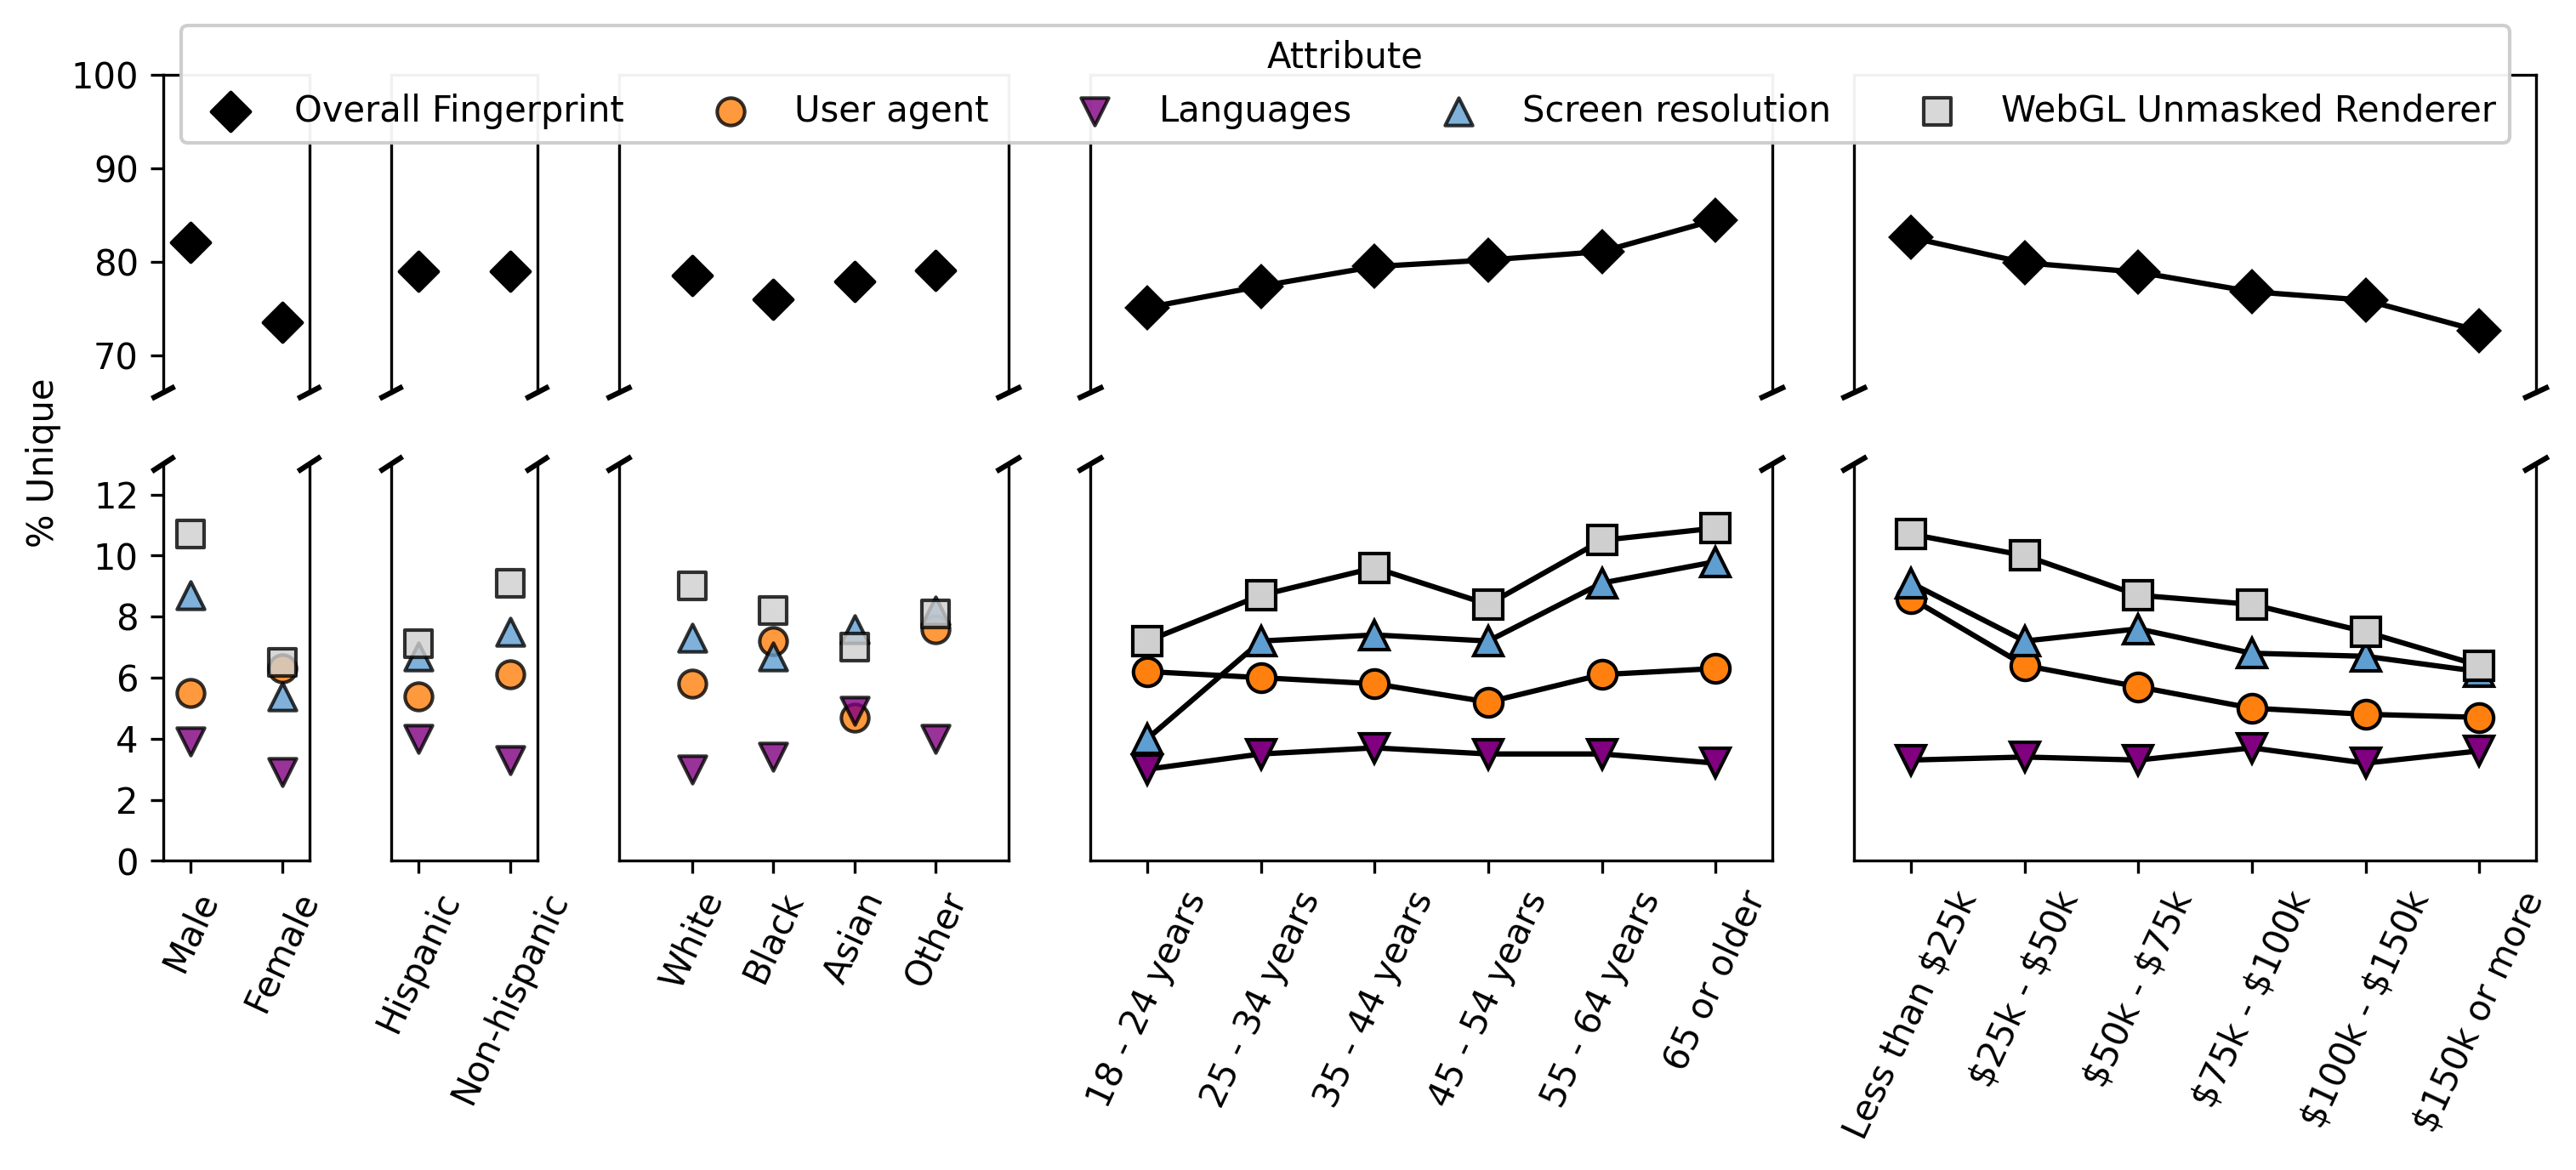

In [ ]:
# groups of plots: categorical ordered and non-ordered
Ds6_unordered = ['Gender', 'Hispanic', 'Race']
Ds6_ordered = ['Age6', 'Income6']
#fig, axes = plt.subplots(1, len(Ds6), figsize=(12, 3), gridspec_kw={'width_ratios': [1.5, 1.5, 4, 7, 7]}) # could define width_ratios based on length of demo groups
# v2: version to put Fingerprint in another plot above
fig, axes = plt.subplots(2, len(Ds6), figsize=(12, 4), gridspec_kw={
    'height_ratios':[1,1.25],
    'width_ratios': [1.5, 1.5, 4, 7, 7]
}, dpi=300)
print('% Unique')
for di, D_name in enumerate(Ds6_unordered + Ds6_ordered):
  ax = axes[1][di]
  plot_df = pct_unique_plot_dfs[D_name]
  dots = []
  ax2 = axes[0][di] # v2
  if D_name in Ds6_unordered:
    dots += [ax2.scatter(
        plot_df.loc['Fingerprint'].index, plot_df.loc['Fingerprint'], label='Fingerprint',
        marker=markers[0],
        edgecolors='black', color='black', s=markersize[0],
    )]
  else:
    dots += [ax2.plot(
              plot_df.loc['Fingerprint'].index, plot_df.loc['Fingerprint'], label='Fingerprint',
              marker=markers[0],
              color='black', markersize=markersize[1],
            )]
  ax2.set_yticks([70,80,90,100] if di==0 else []) # v2
  ax2.set_ylim(66, 100) # v2
  ax2.set_xticks([])
  for ai, a in enumerate(plot_attrs):
    if D_name in Ds6_unordered:
      dots += [ax.scatter(plot_df.loc[a].index, plot_df.loc[a], marker=markers[ai+1], label=a, color=plt_colors[ai],
                          s=markersize[0],
                          alpha=0.8, edgecolors='black')]
    else:
      dots += [ax.plot(
                plot_df.loc[a].index, plot_df.loc[a], label=a,
                marker=markers[ai+1],
                color='black',
                markersize=markersize[1],
                mfc=plt_colors[ai]
          )]
  ax.set_xmargin(0.3) if D_name in Ds6_unordered else ax.set_xmargin(0.1)
  ax2.set_xmargin(0.3) if D_name in Ds6_unordered else ax2.set_xmargin(0.1) # v2
  ax.tick_params(axis='x', rotation=65)
  ax.set_ylim(0, 13) # v2
  ax.set_yticks([0,2,4,6,8,10,12] if di==0 else [])
  if di == 0:
    legend = ax.legend(dots,  ['Overall Fingerprint'] + plot_attrs, scatterpoints=1, loc='upper left', ncol=5, title='Attribute',
                       bbox_to_anchor=(0, 2.15), # v2
                       fancybox=True, framealpha=0.95,
                       )
  make_diagonal_cutouts(ax2, ax, scale=(6/len(Ds6[D_name]))**1.3)
_ = fig.text(0.08, 0.5, '% Unique', va='center', rotation='vertical')

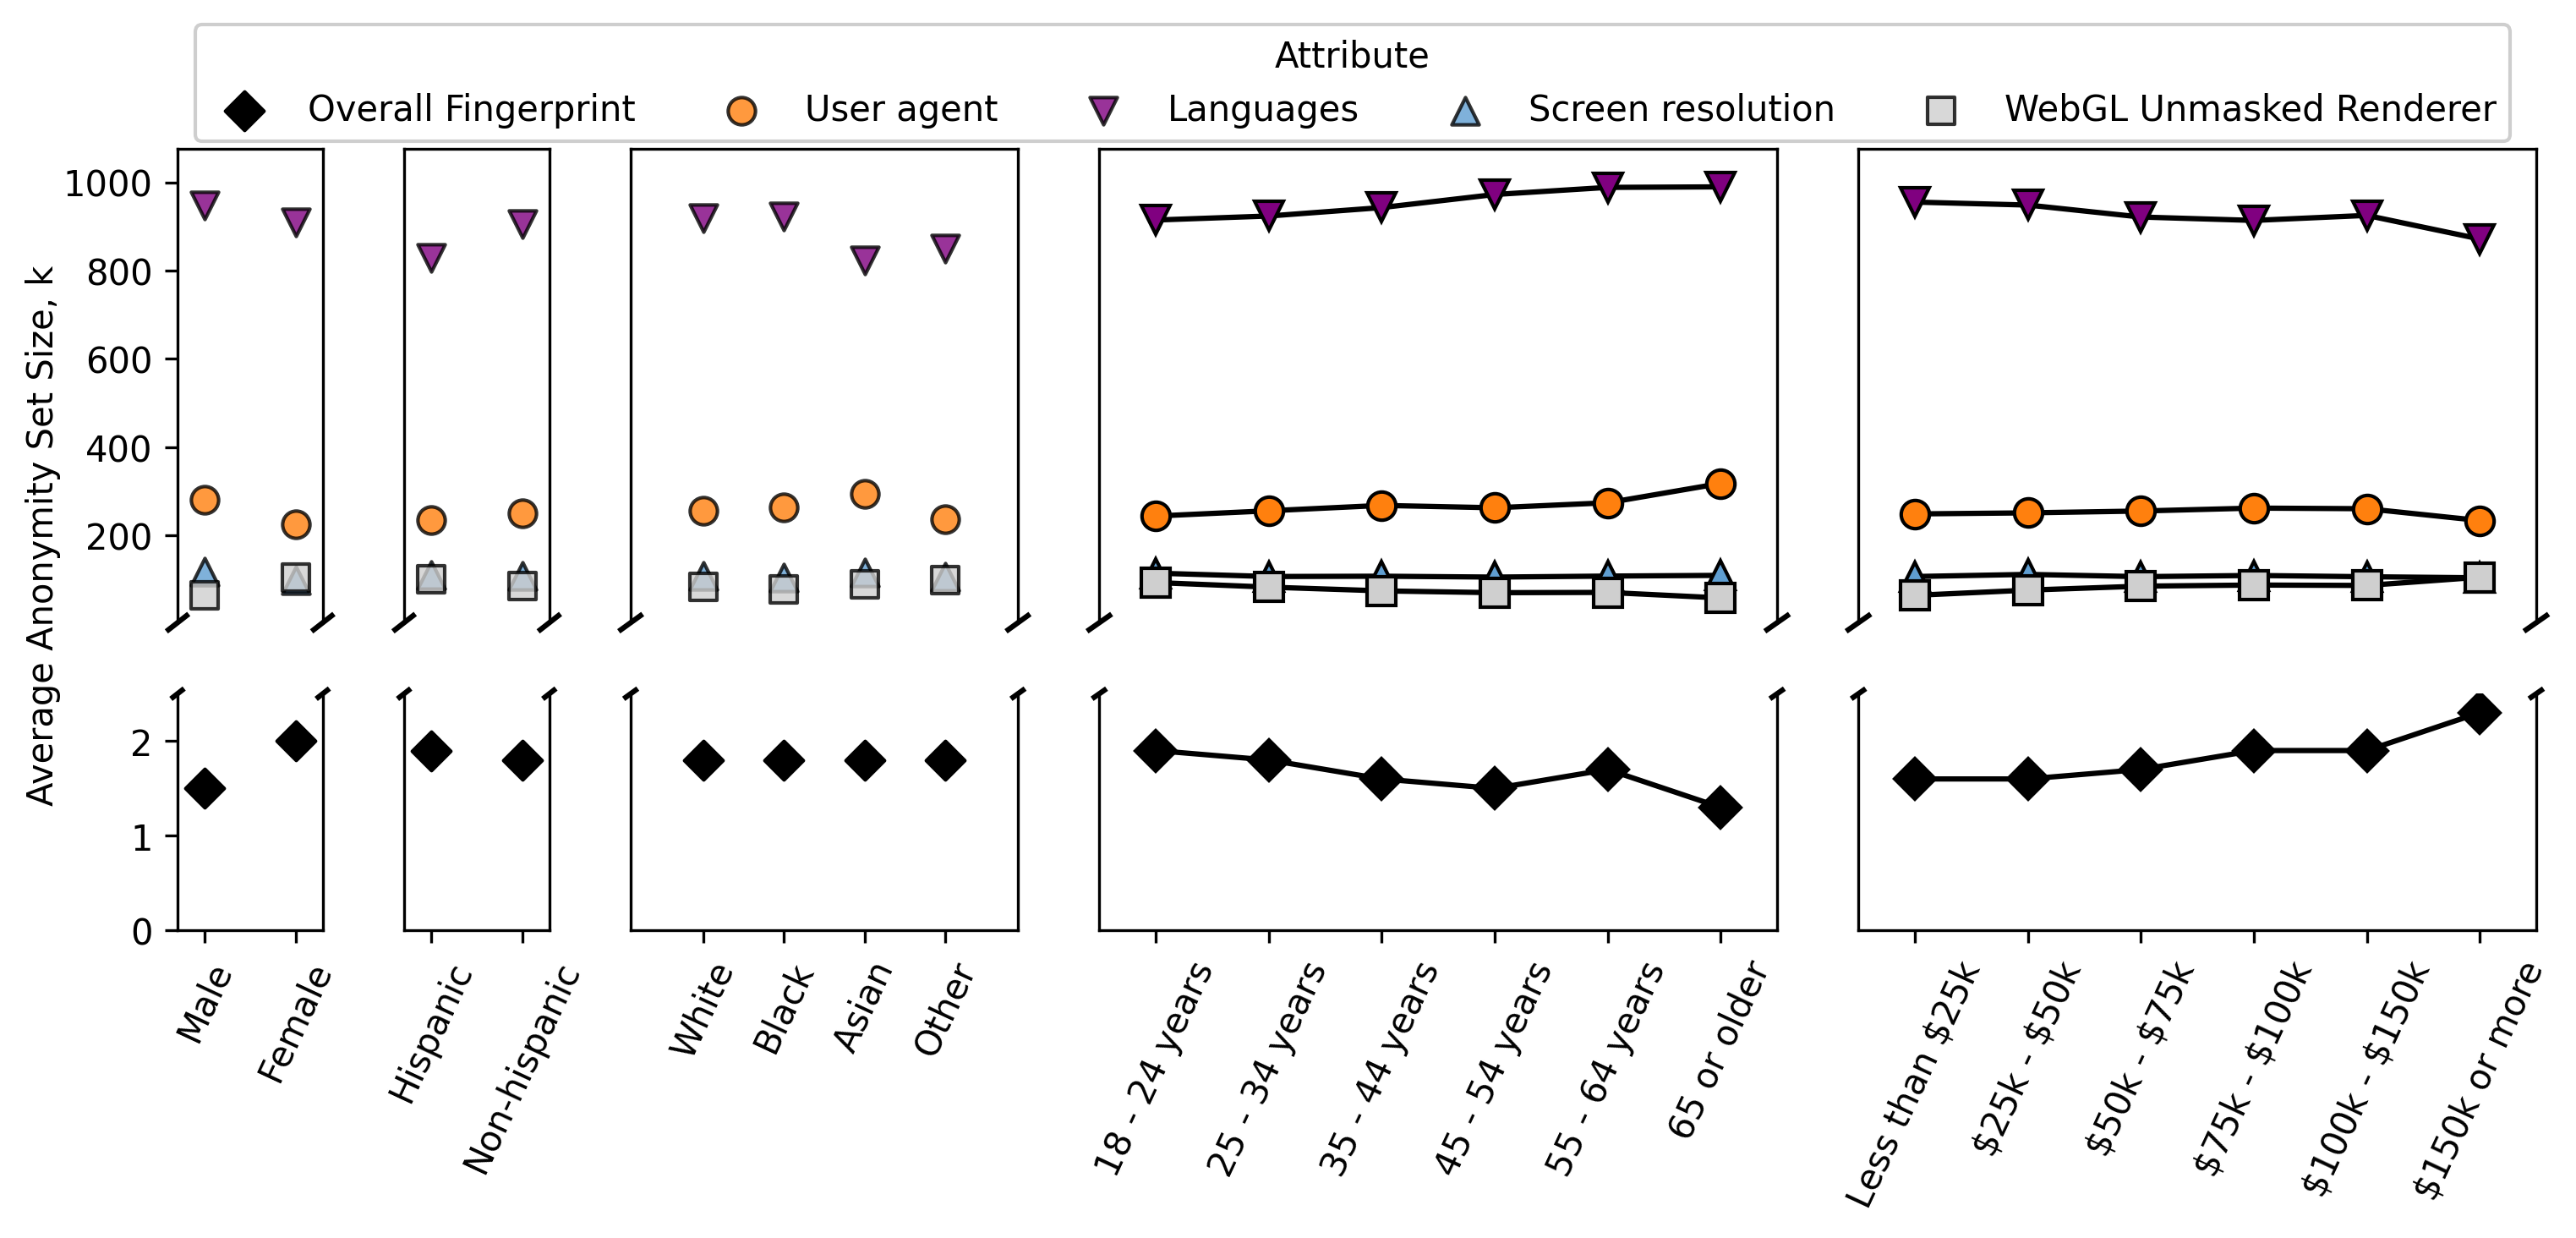

In [ ]:

# groups of plots: categorical ordered and non-ordered
Ds6_unordered = ['Gender', 'Hispanic', 'Race']
Ds6_ordered = ['Age6', 'Income6']
#fig, axes = plt.subplots(1, len(Ds6), figsize=(12, 3), gridspec_kw={'width_ratios': [1.5, 1.5, 4, 7, 7]}) # could define width_ratios based on length of demo groups
# v2: version to put Fingerprint in another plot above
fig, axes = plt.subplots(2, len(Ds6), figsize=(12, 4), gridspec_kw={
    'height_ratios':[2, 1],
    'width_ratios': [1.5, 1.5, 4, 7, 7]
}, dpi=300) # could define width_ratios based on length of demo groups
for di, D_name in enumerate(Ds6_unordered + Ds6_ordered):
  ax = axes[0][di]
  ax2 = axes[1][di]
  plot_df = avg_k_plot_dfs[D_name]
  dots = []
  if D_name in Ds6_unordered:
    dots += [ax2.scatter(
        plot_df.loc['Fingerprint'].index, plot_df.loc['Fingerprint'], label='Fingerprint',
        marker=markers[0],
        edgecolors='black', color='black', s=markersize[0],
    )]
  else:
    dots += [ax2.plot(
              plot_df.loc['Fingerprint'].index, plot_df.loc['Fingerprint'], label='Fingerprint',
              marker=markers[0],
              color='black', markersize=markersize[1],
            )]
  ax.set_xticks([])
  for ai, a in enumerate(plot_attrs):
    if D_name in Ds6_unordered:
      dots += [ax.scatter(plot_df.loc[a].index, plot_df.loc[a], marker=markers[ai+1], label=a, color=plt_colors[ai],
                          s=markersize[0],
                          alpha=0.8, edgecolors='black')]
    else:
      dots += [ax.plot(
                plot_df.loc[a].index, plot_df.loc[a], label=a,
                marker=markers[ai+1],
                color='black',
                markersize=markersize[1],
                mfc=plt_colors[ai]
          )]
  ax.set_xmargin(0.3) if D_name in Ds6_unordered else ax.set_xmargin(0.1)
  ax2.set_xmargin(0.3) if D_name in Ds6_unordered else ax2.set_xmargin(0.1)
  ax2.tick_params(axis='x', rotation=65)
  #ax.set_yscale('log', base=10)
  ax.set_ylim(3, 1075)
  ax2.set_ylim(0, 2.5)
  ax2.set_yticks([0, 1, 2] if di==0 else [])
  # diagonal cutouts
  ax.spines['bottom'].set_visible(False)
  ax2.spines['top'].set_visible(False)
  ax.set_xticks([])
  # make the cut-out diagonals
  # What's cool about this is that now if we vary the distance between ax and ax2 via f.subplots_adjust(hspace=...)
  scale=(6/len(Ds6[D_name]))**1.3
  d = .015
  dx = d*scale  # how big to make the diagonal lines in axes coordinates
  kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
  ax.plot((-dx, +dx), (-d, +d), **kwargs)        # top-left diagonal
  ax.plot((1 - dx, 1 + dx), (-d, +d), **kwargs)  # top-right diagonal
  kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
  ax2.plot((-0.5*dx, +0.5*dx), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
  ax2.plot((1 - 0.5*dx, 1 + 0.5*dx), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
  #make_diagonal_cutouts(ax, ax2, scale=(6/len(Ds6[D_name]))**1.3)
  if di > 0:
    ax.set_yticks([])
  if di == 0:
    legend = ax.legend(dots,  ['Overall Fingerprint'] + plot_attrs, scatterpoints=1, loc='upper left', ncol=5, title='Attribute',
                       bbox_to_anchor=(0, 1.3),
                       fancybox=True, framealpha=0.95,
                       )
_ = fig.text(0.075, 0.5, 'Average Anonymity Set Size, k', va='center', rotation='vertical')

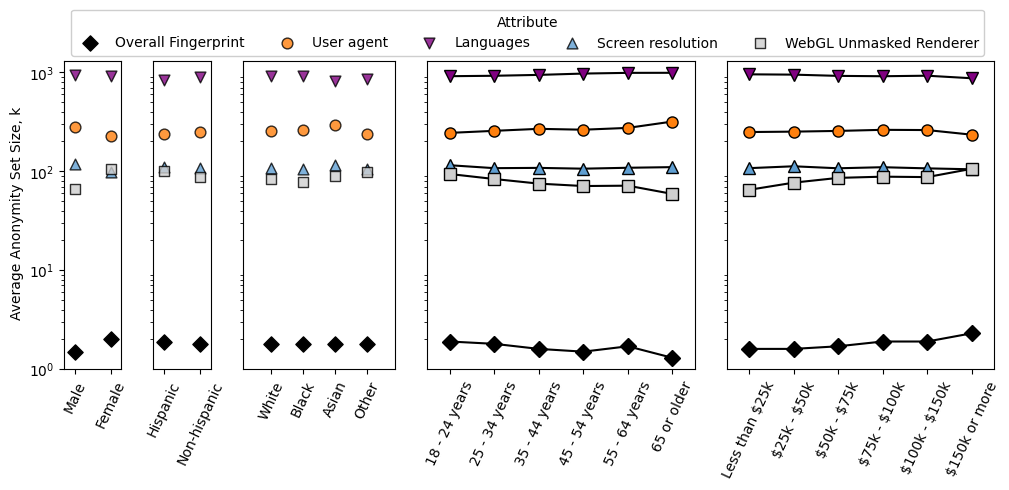

In [ ]:
# Version: Just one plot, all logscale
Ds6_unordered = ['Gender', 'Hispanic', 'Race']
Ds6_ordered = ['Age6', 'Income6']
fig, axes = plt.subplots(1, len(Ds6), figsize=(12, 4), gridspec_kw={'width_ratios': [1.5, 1.5, 4, 7, 7]})
for di, D_name in enumerate(Ds6_unordered + Ds6_ordered):
  ax = axes[di]
  plot_df = avg_k_plot_dfs[D_name]
  dots = []
  if D_name in Ds6_unordered:
    dots += [ax.scatter(
        plot_df.loc['Fingerprint'].index, plot_df.loc['Fingerprint'], label='Fingerprint',
        marker=markers[0],
        edgecolors='black', color='black', s=markersize[0],
    )]
  else:
    dots += [ax.plot(
              plot_df.loc['Fingerprint'].index, plot_df.loc['Fingerprint'], label='Fingerprint',
              marker=markers[0],
              color='black', markersize=markersize[1],
            )]
  for ai, a in enumerate(plot_attrs):
    if D_name in Ds6_unordered:
      dots += [ax.scatter(plot_df.loc[a].index, plot_df.loc[a], marker=markers[ai+1], label=a, color=plt_colors[ai],
                          s=markersize[0],
                          alpha=0.8, edgecolors='black')]
    else:
      dots += [ax.plot(
                plot_df.loc[a].index, plot_df.loc[a], label=a,
                marker=markers[ai+1],
                color='black',
                markersize=markersize[1],
                mfc=plt_colors[ai]
          )]
  ax.set_xmargin(0.3) if D_name in Ds6_unordered else ax.set_xmargin(0.1)
  ax.tick_params(axis='x', rotation=65)
  ax.set_yscale('log', base=10)
  ax.set_ylim(1, 1300)
  if di > 0:
    ax.set_yticks([])
  if di == 0:
    legend = ax.legend(dots,  ['Overall Fingerprint'] + plot_attrs, scatterpoints=1, loc='upper left', ncol=5, title='Attribute',
                       bbox_to_anchor=(0, 1.19),
                       fancybox=True, framealpha=0.95)
_ = fig.text(0.08, 0.5, 'Average Anonymity Set Size, k', va='center', rotation='vertical')

## Minimum attributes to a fingerprint
Comparing the minimum number of browser attributes needed to identify a user

Suppose users in group A tend to be easy to fingerprint with just a few browser attributes, vs this is not the case for users in group B.
We might then say group A is at greater risk.

Idea for how to measure this potential risk:
For each user, find the minimal number of attributes needed to uniquely identify them in the sample.
Then for each group, take the average over these values (median) as the avg minimal number of attributes needed to fingerprint users in the group.
Present this in a table.

#### Make a table: Minimal number of browser attributes needed to fingerprint users in the sample.

To do this:
- Assign to each user in the sample, the minimal number of attributes needed to uniquely identify them, called A_min
For each demographic group:
- Take all users falling into that group, take their A_min values, and compute the descriptive statistics

Algorithm sketch

Call:
- A_min(u) the A_min for user u
- attrs_list = list of attribute names that can be used to make a fingerprint
- |A| = |attrs_list|

Setup:
- Assign A_min(u) = inf to each user
- Order attrs_list by k in ascending order << for performance
```
For a_i in [1, …|A|]:
  attrs_a_i = // get combinations of attrs_list of size a_i
  for attributes in attrs_combins
    us = {u | A_min(u) > a_i}
    // make fingerprint for each u in us using attributes
    fingerprints = [f(u[attributes]) for u in us]
		// compute value counts for fingerprints
		f_vcounts = { f: |{u s.t. f(u[attributes])==f for u in us}| }
		// check if any users in us have a unique fingerprint
		for u in us:
			if (f_vcounts[f(u[attributes])] == 1):
				assign A_min(u) = a_i
```



In [ ]:
# The following routine takes a long time. So we cache the data


import itertools

def get_a_min():
  """
  Returns a mapping of user responseId to minimum number of attributes (a) needed to create unique fingerprint
  """
  # get the ordered list of attribute names
  attrs_list = all_users_unicity_df.drop('Fingerprint').sort_values('avg k', ascending=True).index.tolist()
  assert(set(stable_ba_names) == set(attrs_list))
  A_n = len(attrs_list)
  a_min_df = sba_df.copy()
  a_min_df['a_min'] = np.inf
  for a_i in range(1, A_n+1):
    # make combinations of attributes of size a_i
    attrs_ai = [list(a) for a in itertools.combinations(attrs_list, a_i)] # uses order of attrs_list
    print('%s: a_i: %s; %s combinations' % (pd.Timestamp.now(), a_i, len(attrs_ai)))
    for attributes in attrs_ai:
      us_df = a_min_df[a_min_df['a_min'] > a_i]
      # todo: must include all users when computing fingerprints
      fingerprints = a_min_df[attributes].apply(get_fingerprint, axis=1)
      f_vcounts = fingerprints.value_counts().to_dict()
      for u_rid, u_fingerprint in fingerprints.loc[us_df.index].to_dict().items():
        if (f_vcounts[u_fingerprint] == 1):
          a_min_df.loc[u_rid, 'a_min'] = a_i
  return a_min_df['a_min']

In [ ]:

a_min_fpath = drive_computed_fpath + '/a_min.csv'

recompute_a_min = False
if recompute_a_min:
  a_min = get_a_min()
  a_min.to_csv(a_min_fpath)

a_min = pd.read_csv(a_min_fpath).set_index('ResponseId')
a_min['a_min'] = a_min['a_min'].astype(float)
a_min.head()

,a_min
ResponseId,
R_107DpGEXCf0M8mM,2.0
R_108GtMMONtiVpcZ,2.0
R_1090e2cXjsXnTzl,3.0
R_10A9vFWq6S6i7UF,2.0
R_10Af4UoJLGqfcak,1.0


Data checks:

The total number of users with a_min=1 should be less than the sum of % unique across the attributes.

In [ ]:
a_min_1_pct = 100*len(a_min[a_min['a_min']==1])/len(a_min)
print('%0.1f%% unique with just one attribute' % a_min_1_pct)
assert(a_min_1_pct < all_users_unicity_df.loc[stable_ba_names]['% unique'].sum())

12.2% unique with just one attribute


count    5088.000000
mean        2.348074
std         1.035687
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         8.000000
Name: a_min, dtype: float64


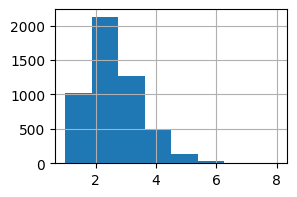

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(3,2))
a_min_vals = a_min['a_min']
print(a_min_vals[a_min_vals < np.inf].describe())
_ = a_min_vals[a_min_vals < np.inf].hist(bins=8, ax=ax) #int(a_min_vals[a_min_vals < np.inf].max()))

In [ ]:
# reconstruct a dataframe that combines user demographics and a_min values.
a_min_df = sba_df.copy()
a_min_df['a_min'] = a_min_df.index.map(a_min['a_min'])
a_min_df.head(3)

,Age,Gender,Hispanic,Race,Income,User agent,Languages,Timezone,Screen resolution,Color depth,Platform,Touch points,WebGL Vendor,WebGL Renderer,WebGL Unmasked Vendor,WebGL Unmasked Renderer,Hardware concurrency,Device memory,Age6,Income6,Fingerprint,F(passive),a_min
ResponseId,,,,,,,,,,,,,,,,,,,,,,,
R_107DpGEXCf0M8mM,35 - 54 years,Male,No,White,"$50,000 - $99,999",Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,"en-US,en",America/New_York,"[900,1600]",24,Win32,0,WebKit,WebKit WebGL,Google Inc. (Intel),"ANGLE (Intel, Intel(R) HD Graphics 3000 Direct...",8.0,8.0,45 - 54 years,"$75,000 - $99,999",6131561411520984098,-4709360641982317263,2.0
R_108GtMMONtiVpcZ,35 - 54 years,Male,No,White,"Less than $50,000",Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,"en-US,en",America/Los_Angeles,"[900,1440]",24,Win32,0,WebKit,WebKit WebGL,Google Inc. (NVIDIA),"ANGLE (NVIDIA, NVIDIA GeForce RTX 3060 (0x0000...",12.0,8.0,35 - 44 years,"$25,000 - $49,999",6019577566895203886,2689765234155432112,2.0
R_1090e2cXjsXnTzl,35 - 54 years,Female,No,White,"$50,000 - $99,999",Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,"en-US,en",America/Chicago,"[720,1280]",24,Win32,10,WebKit,WebKit WebGL,Google Inc. (Google),"ANGLE (Google, Vulkan 1.3.0 (SwiftShader Devic...",8.0,8.0,45 - 54 years,"$50,000 - $74,999",-4064787592481622505,2793275457060046947,3.0


### Create Table: Minimal number of browser attributes needed to fingerprint users in the sample.

```
Group, n, Median **a_min**, a_min <= 1, a_min <= 2, ..., a_min <= 13
Entire sample
Male
Female
...
```
Where each row corresponds to either the entire sample or a demographic subgroup.

And each row contains
- the median number of attributes needed to uniquely identify users
- the % of users unique using a or fewer attributes, for a=1,2,...13

Do this for full demographics set as well as for collapsed income and age groups (3 groups)

In [ ]:
def get_min_a_row(a_min):
  """Returns a row of the table for the given users"""
  n = len(a_min)
  med = a_min.median()
  return [n, med] + [round(100*len(a_min[a_min <= a])/n, 1) for a in range(1, 14)]

In [ ]:
agg_min_a_df = pd.DataFrame(
    [['Entire sample'] + get_min_a_row(a_min_df['a_min'])],
columns=['Group', 'n', 'median min_a'] + [a for a in range(1,14)]).set_index('Group')
agg_min_a_df3 = agg_min_a_df.copy()
agg_min_a_df

,n,median min_a,1,2,3,4,5,6,7,8,9,10,11,12,13
Group,,,,,,,,,,,,,,,
Entire sample,8439,3.0,12.2,37.4,52.5,58.2,59.9,60.3,60.3,60.3,60.3,60.3,60.3,60.3,60.3


In [ ]:
# Handle gender
for g in ['Male', 'Female', 'Other']:
  agg_min_a_df3.loc[g] = get_min_a_row(a_min_df[a_min_df['Gender']==g]['a_min'])
# Handle age group
for demo in ['18 - 34 years', '35 - 54 years', '55 or older']:
  agg_min_a_df3.loc[demo] = get_min_a_row(a_min_df[a_min_df['Age']==demo]['a_min'])
# Hispanic and race
agg_min_a_df3.loc['Hispanic'] = get_min_a_row(a_min_df[a_min_df['Hispanic']=='Yes']['a_min'])
for demo in ['White', 'Black', 'Asian', 'Other or mixed']:
  agg_min_a_df3.loc[demo] = get_min_a_row(a_min_df[a_min_df['Race']==demo]['a_min'])
# Income by sorted groups
for demo in income_groups:
  agg_min_a_df3.loc[demo] = get_min_a_row(a_min_df[a_min_df['Income']==demo]['a_min'])

agg_min_a_df3

,n,median min_a,1,2,3,4,5,6,7,8,9,10,11,12,13
Group,,,,,,,,,,,,,,,
Entire sample,8439.0,3.0,12.2,37.4,52.5,58.2,59.9,60.3,60.3,60.3,60.3,60.3,60.3,60.3,60.3
Male,4256.0,3.0,14.3,41.5,56.4,62.9,64.8,65.2,65.3,65.3,65.3,65.3,65.3,65.3,65.3
Female,3999.0,4.0,9.6,32.7,48.0,52.9,54.2,54.5,54.5,54.5,54.5,54.5,54.5,54.5,54.5
Other,184.0,3.0,19.0,45.1,60.9,66.8,69.0,69.6,69.6,69.6,69.6,69.6,69.6,69.6,69.6
18 - 34 years,4183.0,3.0,11.2,35.5,50.8,55.9,57.3,57.5,57.5,57.5,57.5,57.5,57.5,57.5,57.5
35 - 54 years,3199.0,3.0,12.5,38.4,53.2,59.7,61.5,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0
55 or older,1057.0,3.0,14.9,41.9,57.0,63.1,65.3,65.9,65.9,66.0,66.0,66.0,66.0,66.0,66.0
Hispanic,924.0,3.0,12.3,36.4,54.5,60.5,62.4,63.0,63.0,63.0,63.0,63.0,63.0,63.0,63.0
White,5940.0,3.0,11.8,37.2,52.5,58.6,60.4,60.8,60.8,60.9,60.9,60.9,60.9,60.9,60.9


In [ ]:
# Handle gender
for g in ['Male', 'Female', 'Other']:
  agg_min_a_df.loc[g] = get_min_a_row(a_min_df[a_min_df['Gender']==g]['a_min'])
# Handle age group
for demo in ['18 - 24 years', '25 - 34 years', '35 - 44 years', '45 - 54 years', '55 - 64 years', '65 or older']:
  agg_min_a_df.loc[demo] = get_min_a_row(a_min_df[a_min_df['Age6']==demo]['a_min'])
# Hispanic and race
agg_min_a_df.loc['Hispanic'] = get_min_a_row(a_min_df[a_min_df['Hispanic']=='Yes']['a_min'])
for demo in ['White', 'Black', 'Asian', 'Other or mixed']:
  agg_min_a_df.loc[demo] = get_min_a_row(a_min_df[a_min_df['Race']==demo]['a_min'])
# Income by sorted groups
for demo in income6_groups:
  agg_min_a_df.loc[demo] = get_min_a_row(a_min_df[a_min_df['Income6']==demo]['a_min'])

agg_min_a_df

,n,median min_a,1,2,3,4,5,6,7,8,9,10,11,12,13
Group,,,,,,,,,,,,,,,
Entire sample,8439.0,3.0,12.2,37.4,52.5,58.2,59.9,60.3,60.3,60.3,60.3,60.3,60.3,60.3,60.3
Male,4256.0,3.0,14.3,41.5,56.4,62.9,64.8,65.2,65.3,65.3,65.3,65.3,65.3,65.3,65.3
Female,3999.0,4.0,9.6,32.7,48.0,52.9,54.2,54.5,54.5,54.5,54.5,54.5,54.5,54.5,54.5
Other,184.0,3.0,19.0,45.1,60.9,66.8,69.0,69.6,69.6,69.6,69.6,69.6,69.6,69.6,69.6
18 - 24 years,1303.0,4.0,9.3,32.7,48.6,53.1,54.8,55.1,55.2,55.2,55.2,55.2,55.2,55.2,55.2
25 - 34 years,2880.0,3.0,12.1,36.8,51.9,57.1,58.4,58.6,58.6,58.6,58.6,58.6,58.6,58.6,58.6
35 - 44 years,2038.0,3.0,12.7,38.2,52.9,59.4,61.2,61.6,61.6,61.6,61.6,61.6,61.6,61.6,61.6
45 - 54 years,1161.0,3.0,12.2,38.7,53.7,60.4,62.1,62.6,62.6,62.6,62.6,62.6,62.6,62.6,62.6
55 - 64 years,712.0,3.0,14.5,40.2,54.5,61.7,63.8,64.5,64.5,64.6,64.6,64.6,64.6,64.6,64.6


#### Plot distributions of minimal browser attributes needed

- x-axis: minimal number of attributes needed to create unique fingerprint, a
- y-axis: % unique with a or fewer attributes

Create a plot for each demographic category.

In each plot, plot the distribution for each subgroup with a different curve color. Plot the overall distribution in gray




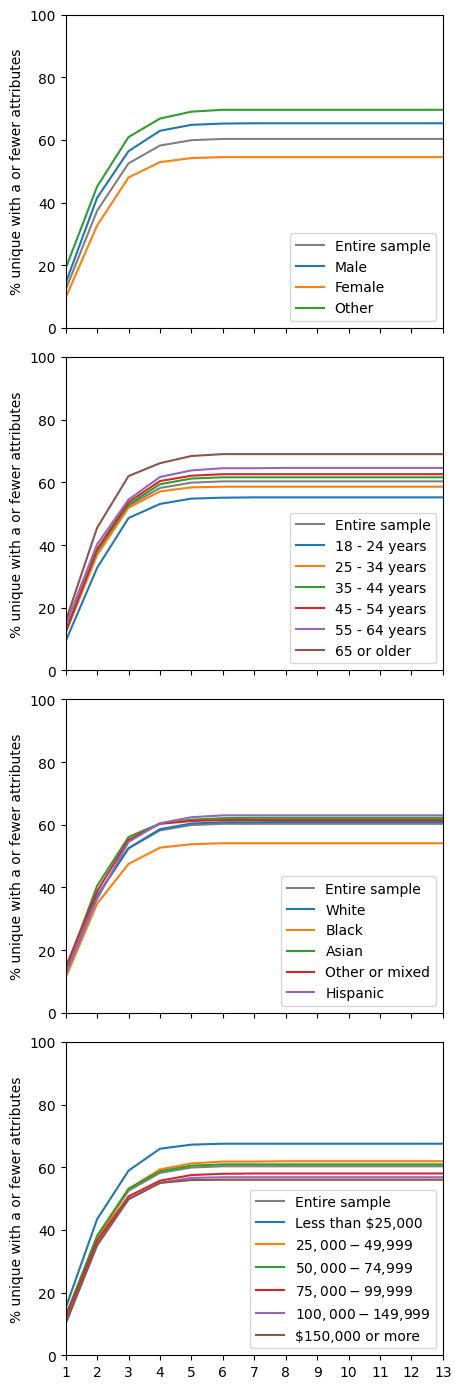

In [ ]:
fig_w, fig_h = 4.5, 3.5
# Horizontally aligned: this is how I would like to display the plots. but this doesn't show up well in google docs.
# fig, axes = plt.subplots(1, 4, figsize=(4*fig_w, fig_h), sharex=True, sharey=True)#, dpi=300)
# Vertically aligned
fig, axes = plt.subplots(4, 1, figsize=(fig_w, 4*fig_h), sharex=True, sharey=True)#, dpi=300)
plt.tight_layout()
ax = axes[0]
# fig, ax = plt.subplots(1,1,figsize=(fig_w, fig_h))

ax.set_ylim(0, 100)
ax.set_ylabel('% unique with a or fewer attributes')
ax.set_xlim(1, 13)
ax.set_xticks([a for a in range(1,14)])

# plot overall
ax.plot(agg_min_a_df.loc['Entire sample', [a for a in range(1,14)]], color='gray', label='Entire sample')
for g in ['Male', 'Female', 'Other']:
  ax.plot(agg_min_a_df.loc[g, [a for a in range(1,14)]], label=g)

ax = axes[1]
ax.plot(agg_min_a_df.loc['Entire sample', [a for a in range(1,14)]], color='gray', label='Entire sample')
for demo in ['18 - 24 years', '25 - 34 years', '35 - 44 years', '45 - 54 years', '55 - 64 years', '65 or older']:
  ax.plot(agg_min_a_df.loc[demo, [a for a in range(1,14)]], label=demo)

ax = axes[2]
ax.plot(agg_min_a_df.loc['Entire sample', [a for a in range(1,14)]], color='gray', label='Entire sample')
# Hispanic and race
demo = 'Hispanic'
for demo in ['White', 'Black', 'Asian', 'Other or mixed', 'Hispanic']:
  ax.plot(agg_min_a_df.loc[demo, [a for a in range(1,14)]], label=demo)

ax = axes[3]
ax.plot(agg_min_a_df.loc['Entire sample', [a for a in range(1,14)]], color='gray', label='Entire sample')
# Income by sorted groups
for demo in income6_groups:
  ax.plot(agg_min_a_df.loc[demo, [a for a in range(1,14)]], label=demo)

for ax in axes:
  # ax.set_xlabel('min number of attributes for fingerprint, a')
  ax.set_ylabel('% unique with a or fewer attributes')
  _ = ax.legend(loc='lower right')

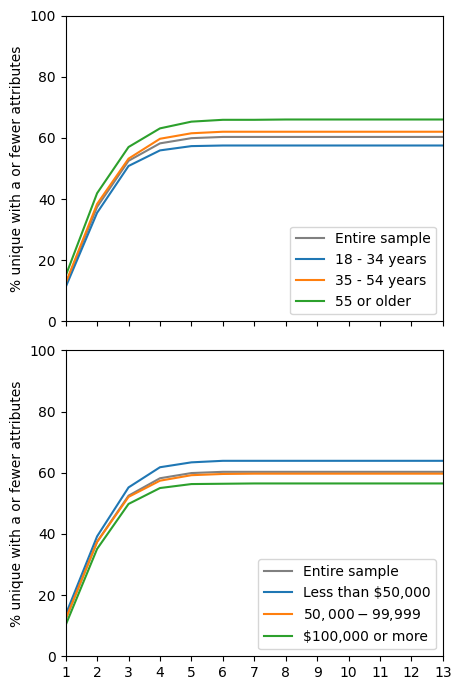

In [ ]:
# Also do this with the reduced income and age groups

fig_w, fig_h = 4.5, 3.5
# Vertically aligned
fig, axes = plt.subplots(2, 1, figsize=(fig_w, 2*fig_h), sharex=True, sharey=True)#, dpi=300)
plt.tight_layout()
ax = axes[0]
# fig, ax = plt.subplots(1,1,figsize=(fig_w, fig_h))

ax.set_ylim(0, 100)
ax.set_ylabel('% unique with a or fewer attributes')
ax.set_xlim(1, 13)
ax.set_xticks([a for a in range(1,14)])

ax.plot(agg_min_a_df3.loc['Entire sample', [a for a in range(1,14)]], color='gray', label='Entire sample')
for demo in ['18 - 34 years', '35 - 54 years', '55 or older']:
  ax.plot(agg_min_a_df3.loc[demo, [a for a in range(1,14)]], label=demo)

ax = axes[1]
ax.plot(agg_min_a_df3.loc['Entire sample', [a for a in range(1,14)]], color='gray', label='Entire sample')
# Income by sorted groups
for demo in income_groups:
  ax.plot(agg_min_a_df3.loc[demo, [a for a in range(1,14)]], label=demo)

for ax in axes:
  # ax.set_xlabel('min number of attributes for fingerprint, a')
  ax.set_ylabel('% unique with a or fewer attributes')
  _ = ax.legend(loc='lower right')